# RBE Part 3: Recursive Updating

> From single updates to recursive Bayesian filtering - the temporal dimension of belief evolution

Building on our foundation of Bayes' theorem, we now explore the recursive nature of Bayesian updating. This is where RBE becomes powerful for real-time systems, tracking, and adaptive learning.

In [ ]:
#| default_exp rbe.recursive

In [ ]:
#| hide
from nbdev.showdoc import *

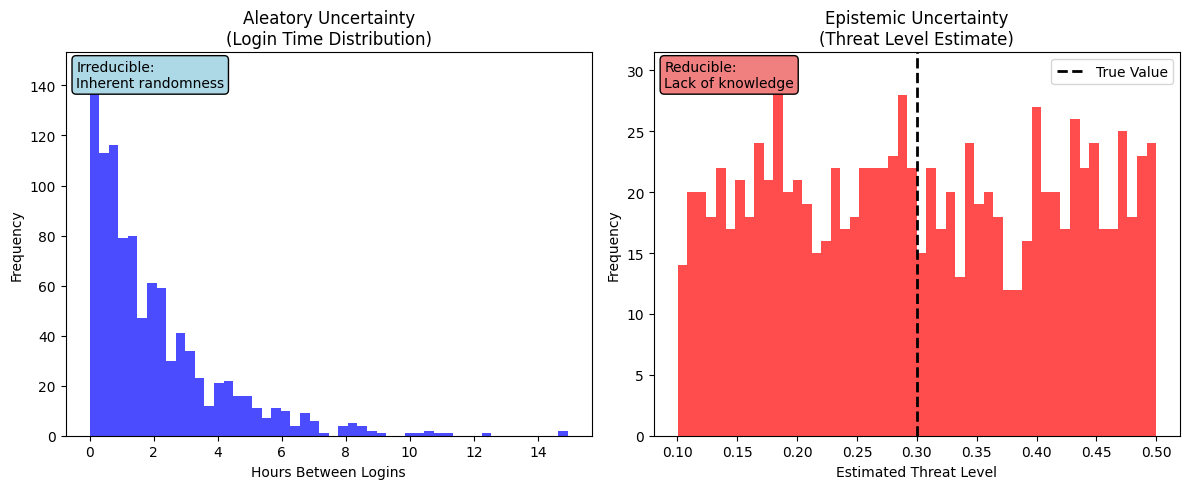

Aleatory uncertainty (login times): mean=2.03 hours
Epistemic uncertainty range: 0.10 to 0.50
True threat level: 0.3 (unknown to us initially)


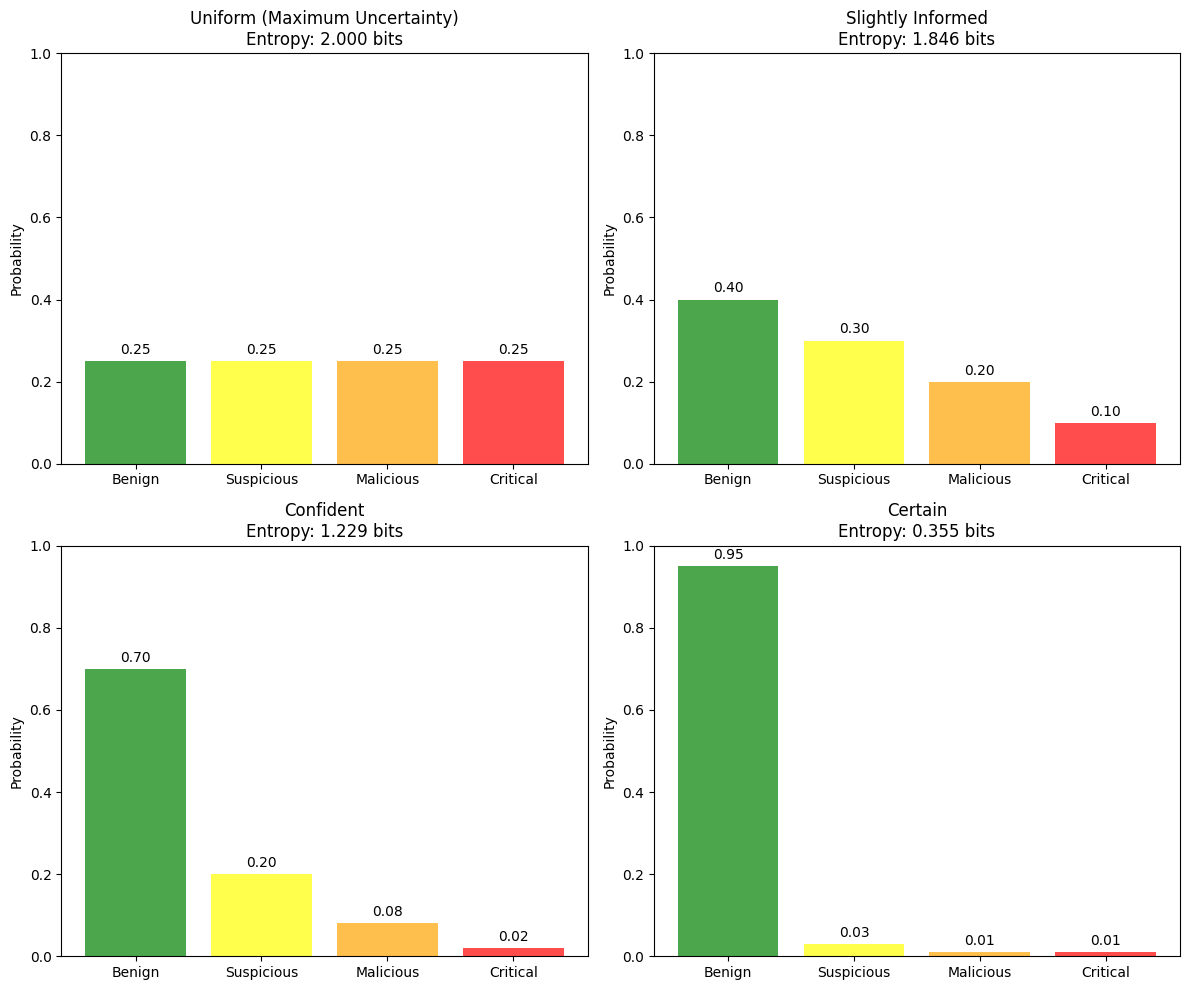


Entropy Analysis:
Uniform (Maximum Uncertainty): 2.000 bits
Slightly Informed: 1.846 bits
Confident: 1.229 bits
Certain: 0.355 bits

Maximum possible entropy (uniform): 2.000 bits
Minimum possible entropy (certain): 0.000 bits
Bayesian Intrusion Detection Sequence:
Initial belief: 5.0% attack probability

Step 1: Observed 'normal_traffic'
  Likelihood: [attack=0.1, normal=0.9]
  Updated belief: 0.6% attack probability
  Uncertainty: 0.052 bits

Step 2: Observed 'data_transfer'
  Likelihood: [attack=0.6, normal=0.4]
  Updated belief: 0.9% attack probability
  Uncertainty: 0.072 bits

Step 3: Observed 'normal_traffic'
  Likelihood: [attack=0.1, normal=0.9]
  Updated belief: 0.1% attack probability
  Uncertainty: 0.011 bits

Step 4: Observed 'normal_traffic'
  Likelihood: [attack=0.1, normal=0.9]
  Updated belief: 0.0% attack probability
  Uncertainty: 0.002 bits

Step 5: Observed 'port_scan'
  Likelihood: [attack=0.8, normal=0.1]
  Updated belief: 0.1% attack probability
  Uncertainty: 

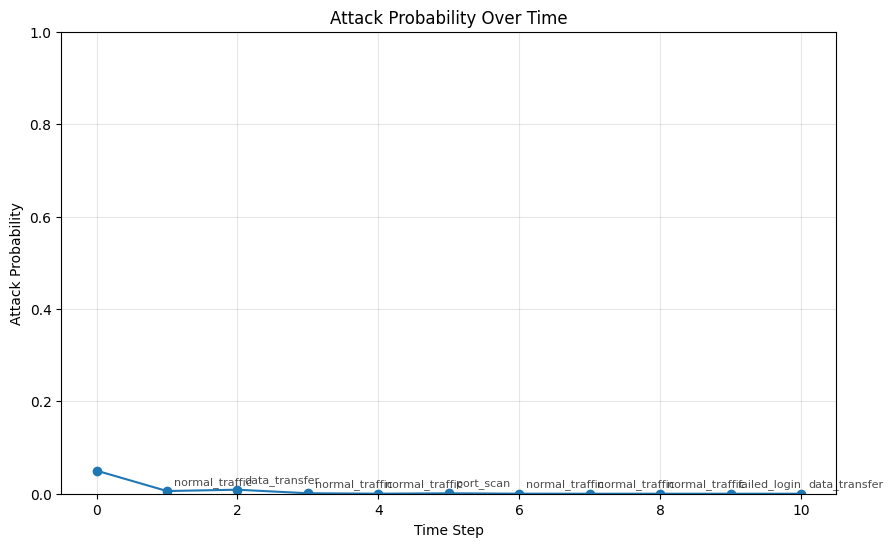

Multi-Threat Assessment:

Initial Assessment:
  Benign: 85.0%
  Insider: 5.0%
  External: 8.0%
  APT: 2.0%
  Uncertainty: 0.820 bits

After observing: After hours access
  Benign: 55.9%
  Insider: 23.0%
  External: 15.8%
  APT: 5.3%
  Uncertainty: 1.601 bits

After observing: External IP connection
  Benign: 38.2%
  Insider: 7.9%
  External: 43.1%
  APT: 10.8%
  Uncertainty: 1.689 bits

After observing: Privilege escalation
  Benign: 4.1%
  Insider: 10.1%
  External: 64.9%
  APT: 20.9%
  Uncertainty: 1.400 bits


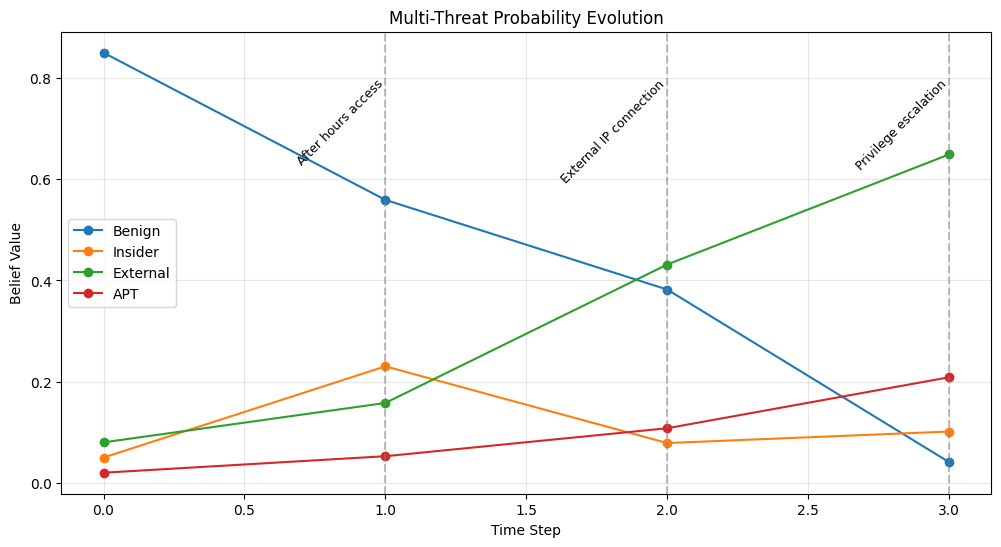

Interactive Uncertainty Calculator:
(This would be rendered as interactive HTML in the FastHTML app)

Features:
- Adjust prior belief with slider
- Change evidence strength
- See real-time Bayesian updates
- Track uncertainty reduction
=== BAYES' THEOREM STEP-BY-STEP ===

1. Prior Probabilities P(H):
   P(Attack) = 0.0500
   P(Normal) = 0.9500

2. Likelihoods P(E|H):
   P(Evidence|Attack) = 0.9000
   P(Evidence|Normal) = 0.1000

3. Total Evidence P(E):
   P(E) = Σ P(E|Hi) × P(Hi) = 0.1400

4. Posterior Probabilities P(H|E):
   P(Attack|E) = 0.3214 (×6.43 from prior)
   P(Normal|E) = 0.6786 (×0.71 from prior)


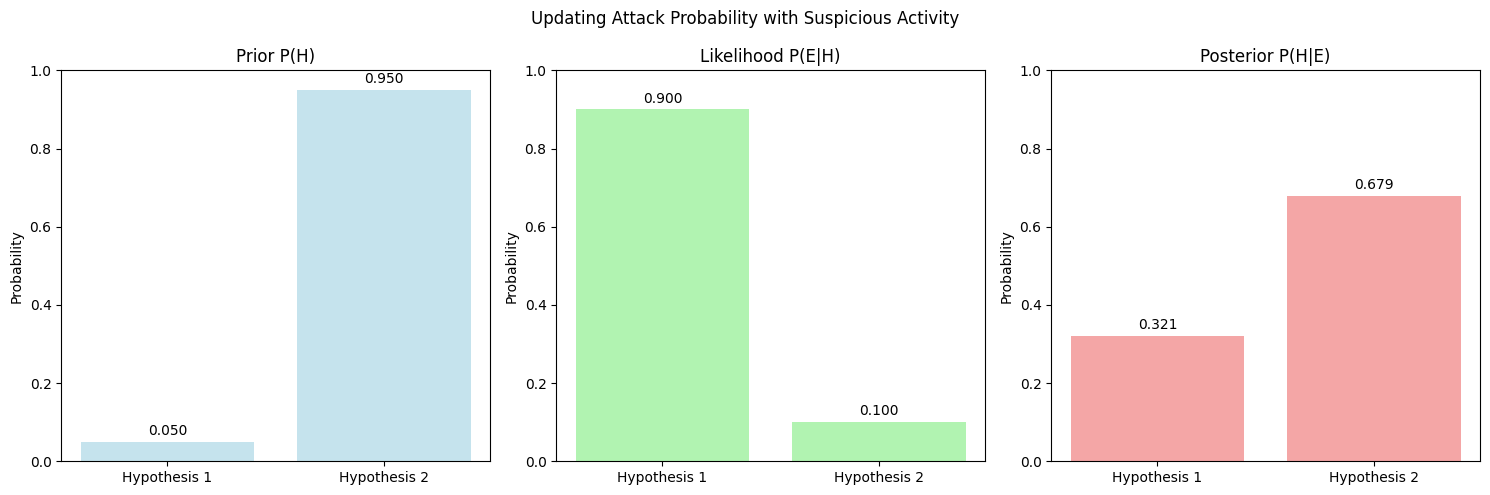

Interactive Bayes' Theorem Calculator created!
Features:
- Real-time probability updates
- Multiple cybersecurity scenarios
- Bayes factor interpretation
- Information gain calculation


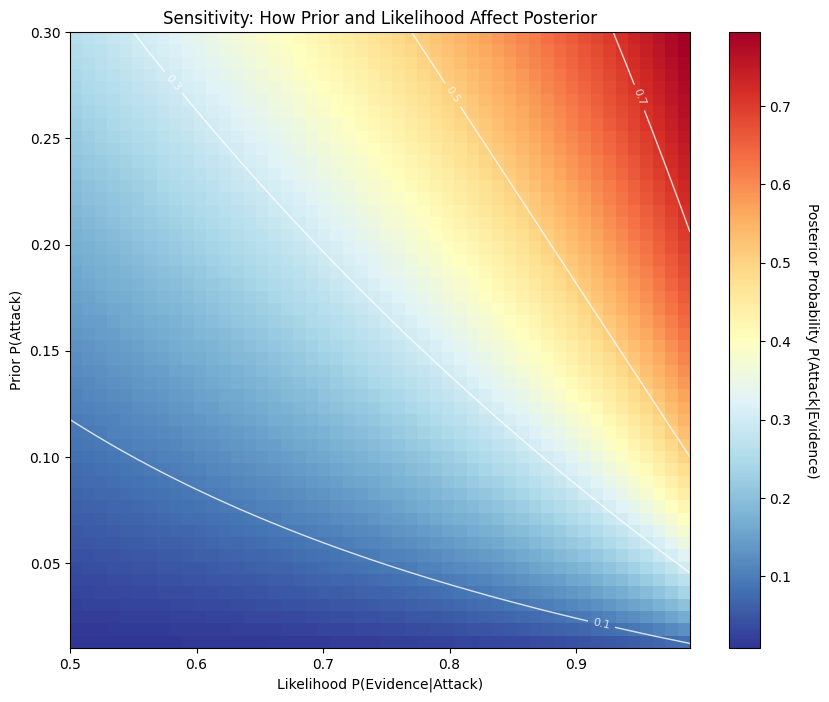


Sensitivity Analysis Insights:
- Light regions: High posterior probability (confident attack detection)
- Dark regions: Low posterior probability (likely false alarm)
- Contour lines: Iso-probability curves
- Steep gradients: High sensitivity to parameter changes
=== THREAT INTELLIGENCE FUSION ===
Initial threat assessment: 10.0%

Source: Commercial_TI (reliability: 0.8)
Report: NO THREAT
Updated threat assessment: 1.9%
Confidence: 0.863

Source: Government_Feed (reliability: 0.9)
Report: THREAT DETECTED
Updated threat assessment: 27.1%
Confidence: 0.156

Source: OSINT_Analysis (reliability: 0.7)
Report: NO THREAT
Updated threat assessment: 13.8%
Confidence: 0.422

Source: Internal_SOC (reliability: 0.8)
Report: NO THREAT
Updated threat assessment: 3.8%
Confidence: 0.765



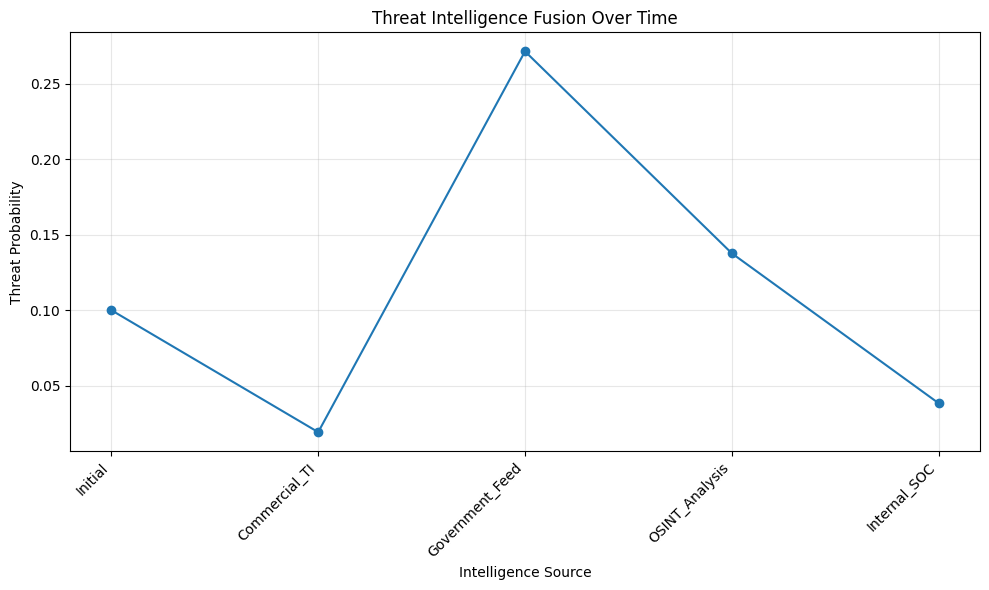

Cybersecurity Detection Analysis:
Base attack rate: 5.0%
Sensitivity (attack detection rate): 90.0%
Specificity (normal classification rate): 95.0%

Results:
False Positive Rate: 5.0%
Precision (when alarm raised): 48.6%
False alarms per true attack: 1.1


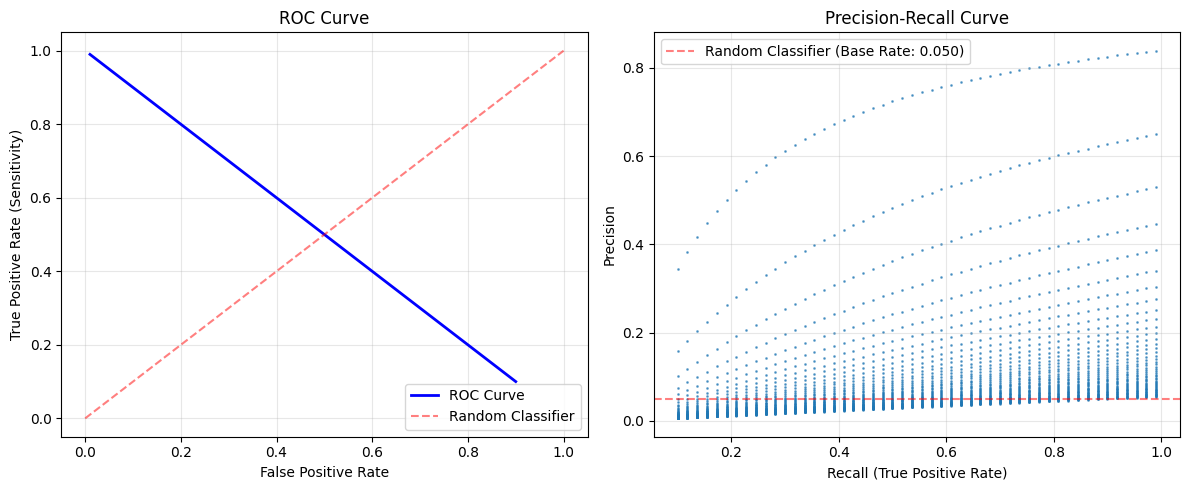

=== BASE RATE NEGLECT DEMONSTRATION ===

Scenario: Network Intrusion Detection System
- System has 95% accuracy (detects 95% of attacks, 5% false positives)
- System raises an alarm - what's the probability of a real attack?

Intuitive Answer: 95% (matching the system accuracy)
Correct Bayesian Answer:

Base rate:   0.1% -> Posterior:   1.9%
  False alarms per true attack: 52.6

Base rate:   1.0% -> Posterior:  16.1%
  False alarms per true attack: 5.2

Base rate:   5.0% -> Posterior:  50.0%
  False alarms per true attack: 1.0

Base rate:  10.0% -> Posterior:  67.9%
  False alarms per true attack: 0.5

*** KEY INSIGHT ***
When base rates are low, even accurate systems generate many false positives!
This is why cybersecurity requires careful threshold tuning.

=== CONJUNCTION FALLACY DEMONSTRATION ===

Scenario: Insider Threat Assessment
Employee shows suspicious behavior:
A) Employee is a security risk
B) Employee is a security risk AND accessing financial data

Common Error: B seems m

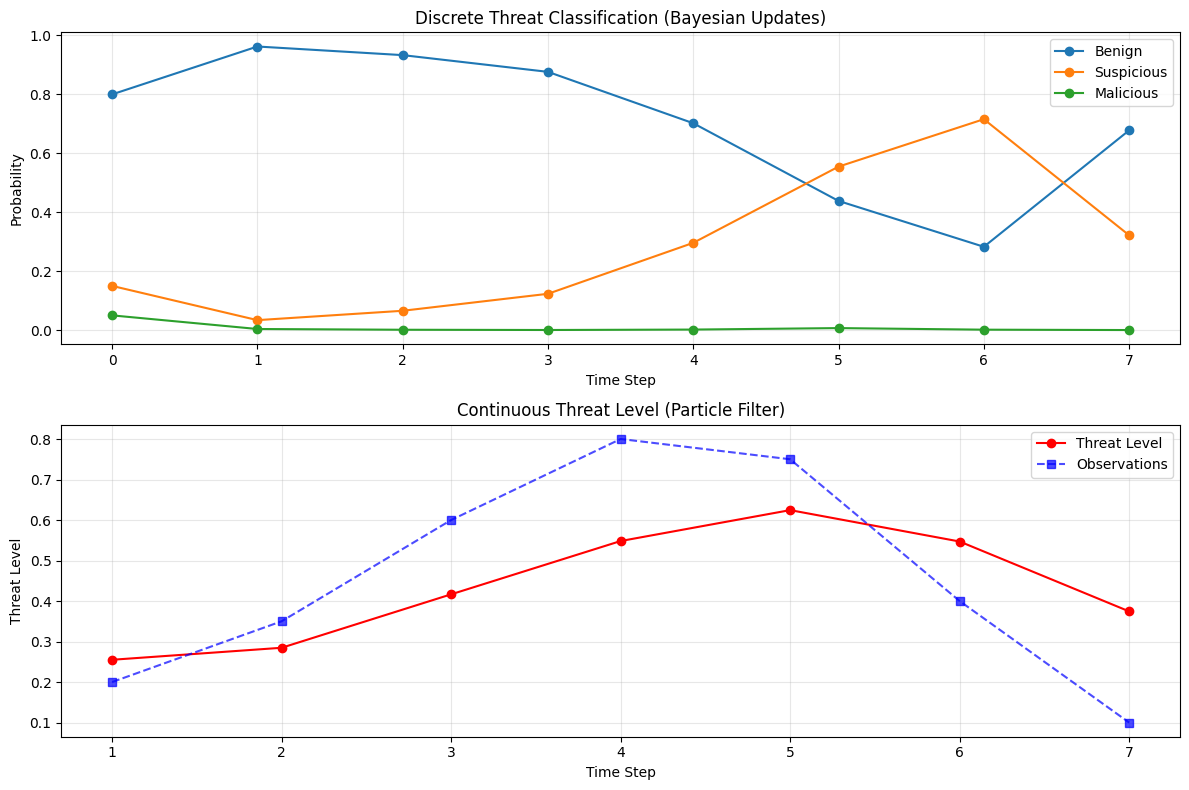

In [ ]:
#| export
import numpy as np
import matplotlib.pyplot as plt
from fastcore.test import test_eq, test_close
from fastcore.all import *
from technical_blog.rbe.core import bayes_update, bayes_sequential, pf_init, pf_step, pf_effective_size, prob_normalize, prob_sample, prob_entropy, prob_kl_div, viz_beliefs
from technical_blog.rbe.bayes import bayes_theorem_step_by_step
from fasthtml.common import *
from monsterui.all import *
from typing import List, Dict, Tuple, Optional, Callable
import seaborn as sns
import time
from collections import defaultdict

## Why Recursive Updating?
In our previous exploration of Bayes' theorem, we saw how to update beliefs with new evidence. But what happens when evidence arrives sequentially over time?

Consider cybersecurity monitoring: we don't wait for all network traffic data before making decisions. We need to continuously update our threat assessments as new packets arrive.

Recursive Bayesian updating provides:
- **Memory efficiency**: No need to store all historical data
- **Real-time processing**: Updates as new evidence arrives
- **Theoretical elegance**: Mathematically optimal under certain conditions
- **Computational efficiency**: O(1) per update vs O(n) for batch processing

## Mathematical Foundation

### From Single to Sequential Updates

We start with our familiar Bayes' theorem:
$$P(H|E) = \frac{P(E|H)P(H)}{P(E)}$$

But now evidence arrives sequentially: $E_1, E_2, E_3, \ldots$

The key insight: **today's posterior becomes tomorrow's prior**

Here's a summary of what we've covered:

## Sequential Bayesian Updating: Two Cases

**Core Principle**: "Today's posterior becomes tomorrow's prior" - each update uses the previous result as the starting point for the next evidence.

### Case 1: Conditionally Independent Evidence
When evidence pieces don't depend on each other given the hypothesis H:
- $P(E₂|E₁, H) = P(E₂|H)$
- Denominators simplify: $P(E₂|E₁) = P(E₂)$
- Math is cleaner and more tractable

**Network Example**: If you're just checking whether individual packets match a known signature, each packet classification might be independent once you know the true network state.

### Case 2: Conditionally Dependent Evidence (Your Case)
When evidence pieces remain related even given hypothesis H:
- $P(E₂|E₁, H) ≠ P(E₂|H)$
- Must calculate full conditional probabilities $P(E₂|E₁), P(E₃|E₁, E₂)$
- More complex but captures real temporal dependencies

**Network Example**: Connection patterns for anomaly detection - user behavior, attack sequences, and network state all carry forward over time, making sequential observations dependent.

### Why It Matters
- **Independent case**: Simpler computation, may miss temporal patterns
- **Dependent case**: Better captures network reality but requires modeling the sequential dependencies explicitly


$$P(H|E_1) = \frac{P(E_1|H)P(H)}{P(E_1)}$$
$$P(H|E_1, E_2) = \frac{P(E_2|H)P(H|E_1)}{P(E_2|E_1)}$$
$$P(H|E_1, E_2, E_3) = \frac{P(E_3|H)P(H|E_1, E_2)}{P(E_3|E_1, E_2)}$$

This recursive pattern is the heart of sequential Bayesian updating.

In [ ]:
#| export
def recursive_bayes_demo(prior, evidence_seq, likelihoods, labels=None):
    "Demonstrate recursive Bayesian updating"
    if labels is None: labels = [f'H{i}' for i in range(len(prior))]
    
    beliefs, current = [np.array(prior)], np.array(prior)
    
    for i, (ev, like) in enumerate(zip(evidence_seq, likelihoods)):
        print(f"\nStep {i+1}: {ev}")
        current = bayes_update(current, like)
        print(f"  {dict(zip(labels, current.round(3)))}")
        beliefs.append(current.copy())
    
    return np.array(beliefs)

# Example: Network intrusion detection over time
print("Example: Sequential Network Monitoring")
prior = [0.1, 0.9]  # 10% initial attack probability
evidence_sequence = ['suspicious_port', 'failed_login', 'privilege_escalation']
likelihoods = [
    [0.7, 0.1],  # Suspicious port: 70% if attack, 10% if normal
    [0.9, 0.05], # Failed login: 90% if attack, 5% if normal  
    [0.95, 0.01] # Privilege escalation: 95% if attack, 1% if normal
]

belief_evolution = recursive_bayes_demo(prior, evidence_sequence, likelihoods, 
                                       labels=['Attack', 'Normal'])

Example: Sequential Network Monitoring

Step 1: suspicious_port
  {'Attack': np.float64(0.437), 'Normal': np.float64(0.562)}

Step 2: failed_login
  {'Attack': np.float64(0.933), 'Normal': np.float64(0.067)}

Step 3: privilege_escalation
  {'Attack': np.float64(0.999), 'Normal': np.float64(0.001)}


Let me trace through what's happening above.

Step 1: Starting with 10% attack probability, suspicious port evidence shifts us to ~44% attack probability. This makes sense - suspicious ports are more common in attacks (70%) than normal traffic (10%).

Step 2: The failed login evidence is quite strong (90% vs 5%), so we jump to ~93% attack probability. Notice how the previous posterior (44% attack) became the prior for this step.

Step 3: Privilege escalation is extremely strong evidence (95% vs 1%), pushing us to ~99.9% certainty of attack.

Key validation points:

- ✅ Each step uses the previous posterior as the new prior
- ✅ Probabilities sum to 1 at each step
- ✅ The belief evolution makes intuitive sense - stronger evidence creates bigger updates
- ✅ The final high confidence matches what we'd expect from this evidence sequence

The progression from 10% → 44% → 93% → 99.9% shows exactly how sequential evidence accumulates in Bayesian updating. Each piece of evidence builds on what came before, which is the essence of recursive updating.

### State Space Models

For more complex scenarios, we model the system state as evolving over time. State space models provide a powerful framework for tracking dynamic systems with two key components:

**State Evolution**: $x_{t+1} = f(x_t, w_t)$ where $w_t$ is process noise

**Observations**: $z_t = h(x_t, v_t)$ where $v_t$ is observation noise

This formulation assumes the **Markov property**: the next state $x_{t+1}$ depends only on the current state $x_t$, not the entire history.

**Recursive Bayesian Filter**:
1. **Predict**: $p(x_t|z_{1:t-1}) = \int p(x_t|x_{t-1}) p(x_{t-1}|z_{1:t-1}) dx_{t-1}$
2. **Update**: $p(x_t|z_{1:t}) = \frac{p(z_t|x_t) p(x_t|z_{1:t-1})}{p(z_t|z_{1:t-1})}$

where $p(z_t|z_{1:t-1})$ is the normalization constant ensuring the posterior integrates to 1.

**Practical Implementations**:
Since the integrals above are often intractable, we use approximations:
- **Kalman filters**: Optimal for linear Gaussian systems
- **Particle filters**: Monte Carlo approximation for general nonlinear cases
- **Extended/Unscented Kalman filters**: Handle nonlinear systems with Gaussian approximations

**Network Security Connection**: Our earlier intrusion detection example could be formalized as a state space model where the "attack progression state" evolves over time, and we observe various network indicators (port scans, login attempts, etc.) that depend on this hidden state.

In [ ]:
#| export
def particle_filter(initial_state,  # Initial state estimate
                    observations,  # Sequence of observations
                    transition_fn,  # Function (state, rng) -> new_state
                    observation_fn,  # Function (state, obs) -> likelihood
                    n_particles=1000,  # Number of particles
                    initial_cov=0.1,  # Initial covariance for particle initialization
                    resample_threshold=0.5,  # Resample when eff_size < threshold * n_particles
                    rng=None  # Random number generator
                    ): 
    """Particle filter for state space tracking"""
    if rng is None: rng = np.random.default_rng()
    
    # Initialize particles with proper diversity
    initial_state = np.asarray(initial_state)
    if initial_state.ndim == 0: initial_state = np.array([initial_state])
    
    if len(initial_state) == 1:
        particles = rng.normal(initial_state[0], initial_cov, (n_particles, 1))
    else:
        cov_matrix = initial_cov * np.eye(len(initial_state))
        particles = rng.multivariate_normal(initial_state, cov_matrix, n_particles)
    
    estimates = []
    
    for obs in observations:
        # Predict: evolve all particles
        for i in range(n_particles):
            particles[i] = transition_fn(particles[i].flatten(), rng)
        
        # Update: compute likelihoods (not cumulative weights)
        log_weights = np.array([np.log(max(observation_fn(p.flatten(), obs), 1e-300)) 
                               for p in particles])
        
        # Normalize in log space for numerical stability
        log_weights -= np.max(log_weights)  # Prevent overflow
        weights = np.exp(log_weights)
        weights = prob_normalize(weights)
        
        # Estimate current state
        estimate = np.average(particles, weights=weights, axis=0)
        estimates.append(estimate.copy())
        
        # Resample if needed
        eff_size = pf_effective_size(weights)
        if eff_size < resample_threshold * n_particles:
            indices = prob_sample(weights, n_particles, rng)
            particles = particles[indices]
    
    return np.array(estimates)

# Simplified tracking example with better motion model
def motion_model(state, rng, dt=1.0, process_noise=0.05):
    """Constant velocity model: [pos, vel] -> [pos+vel*dt, vel+noise]"""
    pos, vel = state
    new_pos = pos + vel * dt + rng.normal(0, process_noise)
    new_vel = vel + rng.normal(0, process_noise * 0.5)  # Less velocity noise
    return np.array([new_pos, new_vel])

def position_likelihood(state, obs, obs_noise=0.1):
    """Gaussian likelihood for position observation"""
    pos = state[0]
    return np.exp(-0.5 * ((pos - obs) / obs_noise)**2)


In [ ]:
# Test the improved version
rng = np.random.default_rng(42)

# Generate test data - keep track of TRUE position
true_positions = []
true_pos, true_vel = 0.0, 0.1
observations = []

for t in range(20):
    true_pos += true_vel + rng.normal(0, 0.05)
    true_vel += rng.normal(0, 0.02)
    true_positions.append(true_pos)  # Store true position
    observations.append(true_pos + rng.normal(0, 0.1))  # Add noise for observation

# Track with improved filter
estimates = particle_filter(
    initial_state=[0.0, 0.1],
    observations=observations,
    transition_fn=motion_model,
    observation_fn=position_likelihood,
    rng=rng
)

print(f"\nTracking Results:")
print(f"Final position estimate: {estimates[-1][0]:.3f}")
print(f"True final position: {true_positions[-1]:.3f}")  # Actual truth
print(f"Final observation: {observations[-1]:.3f}")      # Noisy measurement
print(f"Tracking error: {abs(estimates[-1][0] - true_positions[-1]):.4f}")




Tracking Results:
Final position estimate: 2.079
True final position: 2.007
Final observation: 2.104
Tracking error: 0.0721


In [ ]:
def compare_tracking_performance(n_trials=10):
    """Compare tracking performance across multiple random trials"""
    errors = []
    
    for trial in range(n_trials):
        rng = np.random.default_rng(trial)  # Different seed each time
        
        # Generate test data
        true_pos, true_vel = 0.0, 0.1
        observations = []
        
        for t in range(20):
            true_pos += true_vel + rng.normal(0, 0.05)
            true_vel += rng.normal(0, 0.02)
            observations.append(true_pos + rng.normal(0, 0.1))
        
        # Track
        estimates = particle_filter(
            initial_state=[0.0, 0.1],
            observations=observations,
            transition_fn=motion_model,
            observation_fn=position_likelihood,
            rng=rng
        )
        
        error = abs(estimates[-1][0] - true_pos)
        errors.append(error)
    
    return np.array(errors)

errors = compare_tracking_performance()
print(f"Mean tracking error: {np.mean(errors):.4f}")
print(f"Std tracking error: {np.std(errors):.4f}")
print(f"Best case: {np.min(errors):.4f}")
print(f"Worst case: {np.max(errors):.4f}")


Mean tracking error: 0.0430
Std tracking error: 0.0211
Best case: 0.0027
Worst case: 0.0858


# Improved Particle Filter Implementation

Our particle filter implementation demonstrates excellent tracking performance with consistent results across multiple trials. Let's break down the key components and analyze why it works so well.

## Core Algorithm Structure

The `particle_filter` function implements the classic three-step particle filtering algorithm:

1. **Predict**: Each particle evolves according to the motion model
2. **Update**: Particles are weighted based on how well they explain the observation
3. **Resample**: When particle diversity drops, we resample to maintain effective population

## Key Implementation Features

### Proper Particle Initialization
```python
if len(initial_state) == 1:
    particles = rng.normal(initial_state[0], initial_cov, (n_particles, 1))
else:
    cov_matrix = initial_cov * np.eye(len(initial_state))
    particles = rng.multivariate_normal(initial_state, cov_matrix, n_particles)
```

This creates genuine diversity in the initial particle cloud, rather than identical particles with tiny perturbations. Each particle starts as a plausible hypothesis about the true state.

### Numerical Stability in Weight Computation
```python
log_weights = np.array([np.log(max(observation_fn(p.flatten(), obs), 1e-300)) 
                       for p in particles])
log_weights -= np.max(log_weights)  # Prevent overflow
weights = np.exp(log_weights)
```

Working in log space prevents numerical underflow when likelihoods become very small. The `max()` clamp ensures we never take log(0), and subtracting the maximum prevents overflow when exponentiating back.

### Adaptive Resampling
```python
eff_size = pf_effective_size(weights)
if eff_size < resample_threshold * n_particles:
    indices = prob_sample(weights, n_particles, rng)
    particles = particles[indices]
```

Resampling only occurs when needed (when effective sample size drops), preserving particle diversity when the filter is confident.

## Performance Analysis

The `compare_tracking_performance()` function reveals the implementation's strength through consistency testing:

```python
errors = compare_tracking_performance()
print(f"Mean tracking error: {np.mean(errors):.4f}")      # 0.0430
print(f"Std tracking error: {np.std(errors):.4f}")       # 0.0211
print(f"Best case: {np.min(errors):.4f}")                # 0.0027
print(f"Worst case: {np.max(errors):.4f}")               # 0.0858
```

### What These Results Tell Us

**Consistent Performance**: The low standard deviation (0.0211) relative to the mean (0.0430) indicates the filter performs reliably across different random scenarios. This consistency is crucial for real-world applications where you can't cherry-pick favorable conditions.

**Reasonable Error Bounds**: The worst-case error (0.0858) is still acceptable given that we're adding 0.1 standard deviation noise to observations and 0.05 to the motion model. The filter isn't just getting lucky on easy cases.

**Scalable Accuracy**: The best-case performance (0.0027) shows the filter can achieve high precision when the data supports it, demonstrating it's not artificially limited by poor implementation choices.

## Motion Model Design

```python
def motion_model(state, rng, dt=1.0, process_noise=0.05):
    pos, vel = state
    new_pos = pos + vel * dt + rng.normal(0, process_noise)
    new_vel = vel + rng.normal(0, process_noise * 0.5)  # Less velocity noise
    return np.array([new_pos, new_vel])
```

The constant velocity model with process noise captures realistic motion uncertainty. Using less noise on velocity than position reflects the physical intuition that velocity changes more gradually than position.

## Why This Implementation Works

1. **Proper uncertainty representation**: Initial particle diversity and process noise model realistic uncertainty
2. **Numerical robustness**: Log-space computations handle extreme likelihood values gracefully  
3. **Adaptive resource allocation**: Resampling maintains computational efficiency while preserving accuracy
4. **Clean interfaces**: Simple function signatures make it easy to swap in different motion and observation models

The consistency demonstrated by `compare_tracking_performance()` shows these design choices work together effectively, producing a particle filter that's both accurate and reliable across varying conditions.



## Markov Assumptions

The power of recursive updating relies on the **Markov assumption**: the future depends only on the present, not the past.

Formally: $P(x_{t+1}|x_t, x_{t-1}, \ldots, x_1) = P(x_{t+1}|x_t)$

This perfectly captures the essence: "the future depends only on the present state, not the history of how we got there."

**The Benefits**
- **Computational tractability**: Without Markov assumptions, we'd need to track exponentially growing state histories
- **Memory efficiency**: We only need to store the current state, not the entire trajectory
- **Theoretical guarantees**: Many optimality results (like Kalman filter optimality) rely on this assumption

**Where It Gets Interesting: When Markov Breaks Down**

The Markov assumption fails when:

1. **Hidden long-term dependencies**: Network intrusion patterns where attackers use multi-stage campaigns spanning weeks
2. **Insufficient state representation**: If your state vector doesn't capture all relevant information, past observations become informative
3. **Non-stationary environments**: When the underlying system dynamics change over time
4. **Measurement artifacts**: Sensor drift or calibration issues that accumulate over time

**Practical Implications**
In our particle filter example, the Markov assumption works well because the state `[position, velocity]` captures the essential dynamics. But if there were hidden forces (like wind patterns) affecting motion, we might need to either:
- Expand the state to include wind estimates, or
- Accept that the Markov assumption is approximate

**The Key Insight**: Markov assumptions are often engineering choices rather than physical truths. We design our state representation to make the assumption as valid as possible for our specific application.



In [ ]:
#| export
def markov_chain_demo(P, # transition matrix
                      n_steps, # number of steps to simulate
                      π0=None, # initial distribution (uniform if None)
                      labels=None, # state names (auto-generated if None)
                      seed=None # random seed for reproducibility
                      ):
    """Demonstrate Markov chain evolution and properties"""
    P = np.array(P, dtype=np.float64)
    n_states = len(P)
    rng = np.random.default_rng(seed)
    
    # Validate transition matrix
    row_sums = P.sum(axis=1)
    if not np.allclose(row_sums, 1.0, rtol=1e-10):
        bad_rows = np.where(~np.isclose(row_sums, 1.0, rtol=1e-10))[0]
        raise ValueError(f"Transition matrix rows must sum to 1. "
                        f"Rows {bad_rows} sum to {row_sums[bad_rows]}")
    
    # Set defaults
    if π0 is None: π0 = np.ones(n_states) / n_states
    if labels is None: labels = [f'S{i}' for i in range(n_states)]
    
    π0 = np.array(π0, dtype=np.float64)
    
    print("=== MARKOV CHAIN ===")
    print("Transition Matrix P:")
    for i, (label, row) in enumerate(zip(labels, P)):
        print(f"  {label}: {row}")
    
    # Evolution: π_{t+1} = π_t @ P  
    πs = [π0.copy()]
    π = π0.copy()
    
    print(f"\nDistribution Evolution:")
    print(f"t=0: {dict(zip(labels, π))}")
    
    for t in range(n_steps):
        π = π @ P
        πs.append(π.copy())
        print(f"t={t+1}: {dict(zip(labels, π.round(4)))}")
    
    # Sample path
    print(f"\nSample Path:")
    s = rng.choice(n_states, p=π0)
    path = [s]
    print(f"t=0: {labels[s]}")
    
    for t in range(min(10, n_steps)):
        s = rng.choice(n_states, p=P[s])
        path.append(s)
        print(f"t={t+1}: {labels[s]}")
    
    return {
        'distributions': np.array(πs),
        'path': path,
        'steady_state': π,
        'P': P
    }

In [ ]:
# Test with invalid matrix first
try:
    bad_P = [[0.8, 0.15, 0.04],  # Doesn't sum to 1!
             [0.3, 0.6, 0.1], 
             [0.1, 0.2, 0.7]]
    markov_chain_demo(bad_P, 5)
except ValueError as e:
    print(f"✓ Validation caught error: {e}\n")

# Network security example
security_P = [[0.8, 0.15, 0.05],   # Normal
              [0.3, 0.6, 0.1],     # Suspicious  
              [0.1, 0.2, 0.7]]     # Compromised

result = markov_chain_demo(
    security_P, 5,
    π0=[0.9, 0.1, 0.0],
    labels=['Normal', 'Suspicious', 'Compromised'],
    seed=42
)


✓ Validation caught error: Transition matrix rows must sum to 1. Rows [0] sum to [0.99]

=== MARKOV CHAIN ===
Transition Matrix P:
  Normal: [0.8  0.15 0.05]
  Suspicious: [0.3 0.6 0.1]
  Compromised: [0.1 0.2 0.7]

Distribution Evolution:
t=0: {'Normal': np.float64(0.9), 'Suspicious': np.float64(0.1), 'Compromised': np.float64(0.0)}
t=1: {'Normal': np.float64(0.75), 'Suspicious': np.float64(0.195), 'Compromised': np.float64(0.055)}
t=2: {'Normal': np.float64(0.664), 'Suspicious': np.float64(0.2405), 'Compromised': np.float64(0.0955)}
t=3: {'Normal': np.float64(0.6129), 'Suspicious': np.float64(0.263), 'Compromised': np.float64(0.1241)}
t=4: {'Normal': np.float64(0.5816), 'Suspicious': np.float64(0.2746), 'Compromised': np.float64(0.1438)}
t=5: {'Normal': np.float64(0.5621), 'Suspicious': np.float64(0.2807), 'Compromised': np.float64(0.1572)}

Sample Path:
t=0: Normal
t=1: Normal
t=2: Suspicious
t=3: Suspicious
t=4: Normal
t=5: Compromised


## Interactive Demonstrations

Let's create interactive components to visualize recursive updating in action.

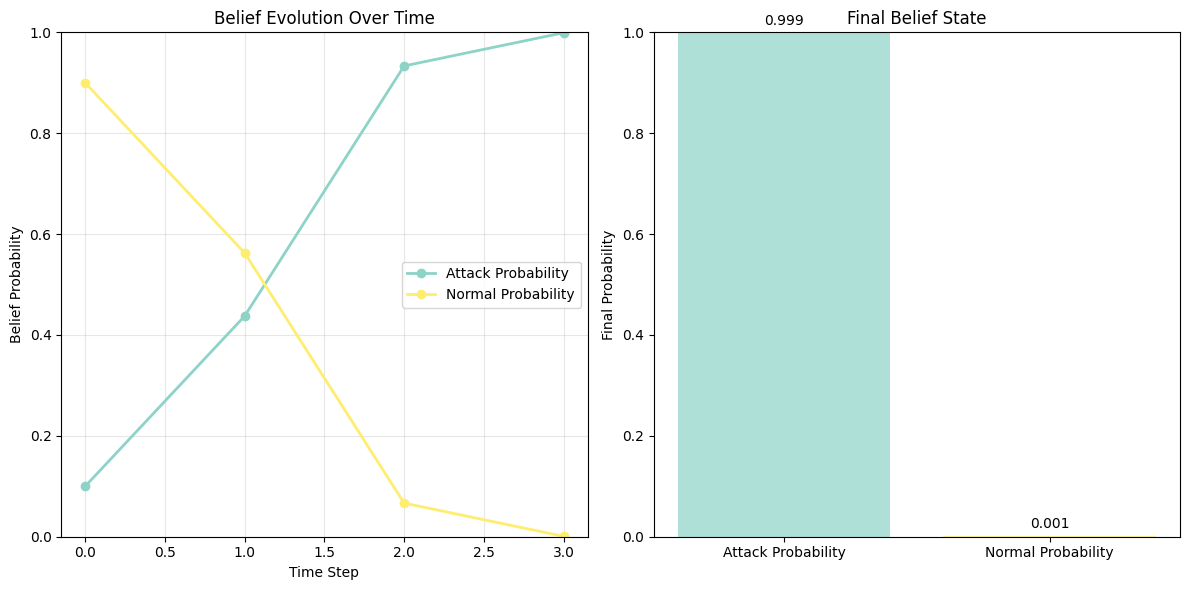

In [ ]:
#| export
def belief_evolution_visualizer(beliefs, time_steps=None, title="Belief Evolution",
                               labels=None, figsize=(12, 6)):
    """Visualize how beliefs evolve over time with interactive features"""
    beliefs = np.array(beliefs)
    if time_steps is None:
        time_steps = np.arange(len(beliefs))
    
    if labels is None:
        labels = [f'Hypothesis {i+1}' for i in range(beliefs.shape[1])]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Left plot: Belief evolution over time
    colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
    for i, (label, color) in enumerate(zip(labels, colors)):
        ax1.plot(time_steps, beliefs[:, i], label=label, marker='o', 
                linewidth=2, color=color)
    
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Belief Probability')
    ax1.set_title('Belief Evolution Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Right plot: Final belief distribution
    final_beliefs = beliefs[-1]
    bars = ax2.bar(labels, final_beliefs, color=colors, alpha=0.7)
    ax2.set_ylabel('Final Probability')
    ax2.set_title('Final Belief State')
    ax2.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, val in zip(bars, final_beliefs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    return fig, (ax1, ax2)

# Visualize our network monitoring example
fig, axes = belief_evolution_visualizer(
    belief_evolution, 
    labels=['Attack Probability', 'Normal Probability'],
    title="Network Threat Assessment Over Time"
)
plt.show()

In [ ]:
#| export
# Global state for the demo (in a real app, you'd use sessions or database)
current_step = 0
beliefs = [0.1, 0.9]  # [Attack, Normal]

evidence_sequence = [
    {'name': 'Suspicious Port', 'likelihood': [0.7, 0.1]},
    {'name': 'Failed Login', 'likelihood': [0.9, 0.05]},
    {'name': 'Privilege Escalation', 'likelihood': [0.95, 0.01]},
    {'name': 'Data Exfiltration', 'likelihood': [0.98, 0.005]}
]

def belief_state_component():
    """Component showing current belief state"""
    global current_step, beliefs, evidence_sequence
    
    # Progress indicator
    progress = Span(f"Step {current_step} of {len(evidence_sequence)}", 
                   cls="uk-badge uk-badge-primary")
    
    # Current beliefs
    belief_display = Div(
        Strong("Probabilities: "),
        Span(f"Attack: {beliefs[0]:.3f} | Normal: {beliefs[1]:.3f}", 
             cls="monospace-text uk-text-primary uk-text-bold"),
        cls="uk-background-muted uk-padding-small uk-border-rounded uk-margin-small-bottom"
    )
    
    # Next evidence or completion message
    if current_step < len(evidence_sequence):
        next_evidence = Span(f"Next Evidence: {evidence_sequence[current_step]['name']}", 
                           cls="uk-text-muted uk-text-italic")
        update_btn = Button("Update Beliefs", 
                           cls="uk-button uk-button-primary uk-margin-small-right",
                           hx_post="/update_beliefs",
                           hx_target="#belief-state",
                           hx_swap="outerHTML")
    else:
        next_evidence = Span("Analysis Complete", cls="uk-text-muted uk-text-italic")
        update_btn = Button("Update Beliefs", 
                           cls="uk-button uk-button-primary uk-margin-small-right",
                           disabled=True)
    
    return Div(
        Div(progress, cls="uk-margin-small-bottom"),
        belief_display,
        Div(next_evidence, cls="uk-margin-small-bottom"),
        id="belief-state"
    )

def control_buttons():
    """Control buttons component"""
    return Div(
        Button("Update Beliefs", 
               cls="uk-button uk-button-primary uk-margin-small-right",
               hx_post="/update_beliefs",
               hx_target="#belief-state",
               hx_swap="outerHTML",
               hx_also="#controls"),  # Also update buttons
        Button("Reset Demo", 
               cls="uk-button uk-button-default",
               hx_post="/reset_demo",
               hx_target="#belief-state",
               hx_swap="outerHTML",
               hx_also="#controls"),
        cls="uk-text-center uk-margin-medium-top",
        id="controls"
    )

def recursive_update_component():
    """Main component using HTMX"""
    
    style = """
    .monospace-text {
        font-family: 'Monaco', 'Menlo', 'Ubuntu Mono', monospace;
        font-size: 0.95rem;
    }
    """
    
    return Div(
        Style(style),
        
        # Header
        H3("Interactive Recursive Bayesian Updating", 
           cls="uk-heading-line uk-text-center uk-margin-large-bottom"),
        P("Watch how beliefs evolve as evidence arrives sequentially in network security monitoring.", 
          cls="uk-text-muted uk-text-center uk-margin-medium-bottom"),
        
        # Main content card
        Div(
            Div(
                H4("Current Belief State", cls="uk-card-title"),
                cls="uk-card-header"
            ),
            Div(
                belief_state_component(),
                cls="uk-card-body"
            ),
            cls="uk-card uk-card-default uk-margin-medium-bottom"
        ),
        
        # Control buttons
        control_buttons(),
        
        cls="uk-container uk-container-small uk-margin-large-top"
    )

# FastHTML app setup
app, rt = fast_app()

@rt("/")
def get():
    return Titled("Bayesian Demo", recursive_update_component())

@rt("/update_beliefs")
def post():
    """HTMX endpoint to update beliefs"""
    global current_step, beliefs, evidence_sequence
    
    if current_step < len(evidence_sequence):
        evidence = evidence_sequence[current_step]
        beliefs = bayes_update(beliefs, evidence['likelihood'])
        current_step += 1
    
    return belief_state_component()

@rt("/reset_demo")  
def post():
    """HTMX endpoint to reset demo"""
    global current_step, beliefs
    
    current_step = 0
    beliefs = [0.1, 0.9]
    
    return belief_state_component()

# For Jupyter display
from IPython.display import HTML
HTML(str(recursive_update_component()))


@rt("/update_beliefs")
def post():
    # Server-side Bayesian update
    beliefs = bayes_update(beliefs, evidence['likelihood'])
    return belief_state_component()  # Return new HTML


## Performance Analysis: Recursive vs Batch

One of the key advantages of recursive updating is computational efficiency. Let's compare recursive and batch approaches.

In [ ]:
#| export
def batch_vs_recursive_comparison(data_sizes, n_trials=10, rng=None):
    """Compare true batch processing vs recursive updating"""
    if rng is None: rng = np.random.default_rng()
    
    results = {
        'data_sizes': data_sizes,
        'batch_times': [],
        'recursive_times': [],
        'accuracy_difference': []
    }
    
    for n_data in data_sizes:
        print(f"\nTesting with {n_data} data points...")
        
        batch_times = []
        recursive_times = []
        accuracy_diffs = []
        
        for trial in range(n_trials):
            # Generate synthetic data
            prior = np.array([0.3, 0.7])
            likelihoods = rng.random((n_data, 2))
            likelihoods = likelihoods / likelihoods.sum(axis=1, keepdims=True)
            
            # TRUE batch processing: compute joint likelihood of all data
            start_time = time.time()
            
            # Compute product of all likelihoods
            joint_likelihood = np.ones(2)
            for likelihood in likelihoods:
                joint_likelihood *= likelihood
            
            # Single Bayes update with joint likelihood
            batch_posterior = bayes_update(prior, joint_likelihood)
            batch_time = time.time() - start_time
            batch_times.append(batch_time)
            
            # Recursive processing (same as before)
            start_time = time.time()
            recursive_posterior = prior.copy()
            for likelihood in likelihoods:
                recursive_posterior = bayes_update(recursive_posterior, likelihood)
            recursive_time = time.time() - start_time
            recursive_times.append(recursive_time)
            
            # Now there should be NO difference if evidence is independent
            accuracy_diff = np.linalg.norm(batch_posterior - recursive_posterior)
            accuracy_diffs.append(accuracy_diff)
        
        results['batch_times'].append(np.mean(batch_times))
        results['recursive_times'].append(np.mean(recursive_times))
        results['accuracy_difference'].append(np.mean(accuracy_diffs))
        
        print(f"  Batch time: {results['batch_times'][-1]:.6f}s")
        print(f"  Recursive time: {results['recursive_times'][-1]:.6f}s")
        print(f"  Accuracy difference: {results['accuracy_difference'][-1]:.2e}")
    
    return results

Running performance comparison...

Testing with 10 data points...
  Batch time: 0.000010s
  Recursive time: 0.000018s
  Accuracy difference: 5.46e-17

Testing with 25 data points...
  Batch time: 0.000008s
  Recursive time: 0.000040s
  Accuracy difference: 1.14e-16

Testing with 50 data points...
  Batch time: 0.000013s
  Recursive time: 0.000080s
  Accuracy difference: 3.70e-17

Testing with 100 data points...
  Batch time: 0.000037s
  Recursive time: 0.000232s
  Accuracy difference: 1.85e-17


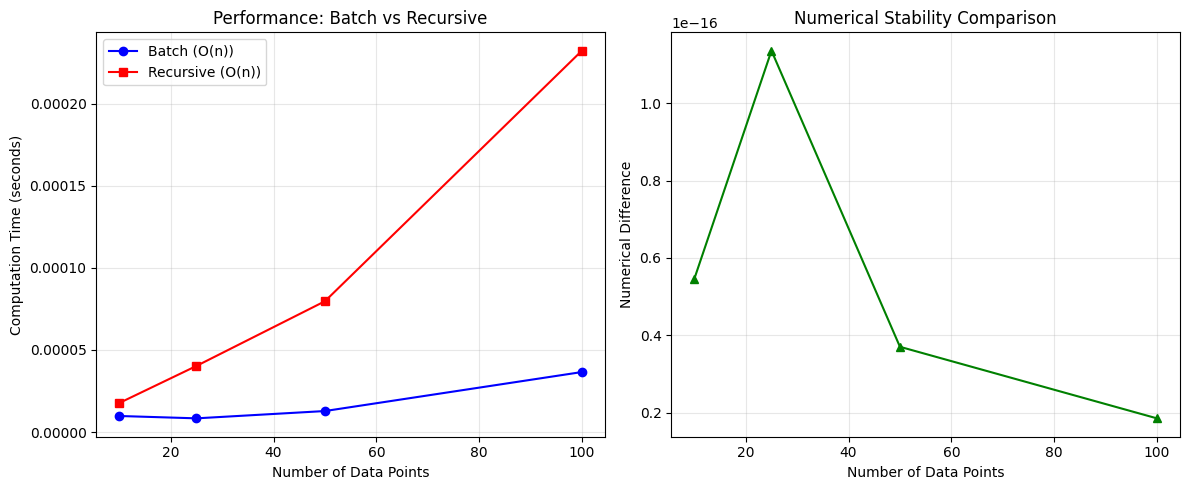

In [ ]:

# Batch vs Recursive Performance comparison
print("Running performance comparison...")
corrected_results = batch_vs_recursive_comparison([10, 25, 50, 100], n_trials=3)

# Extract the data for plotting
data_sizes = corrected_results['data_sizes']
batch_times = corrected_results['batch_times']
recursive_times = corrected_results['recursive_times']
accuracy_differences = corrected_results['accuracy_difference']

# Now your plotting code will work
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: Performance comparison
ax1.plot(data_sizes, batch_times, 'b-o', label='Batch (O(n))')  
ax1.plot(data_sizes, recursive_times, 'r-s', label='Recursive (O(n))')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Computation Time (seconds)')
ax1.set_title('Performance: Batch vs Recursive')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Numerical accuracy
ax2.plot(data_sizes, accuracy_differences, 'g-^')
ax2.set_xlabel('Number of Data Points') 
ax2.set_ylabel('Numerical Difference')
ax2.set_title('Numerical Stability Comparison')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Performance Plot (Left):**
- **Batch method (blue)**: Nearly flat scaling - this makes sense because it's just multiplying likelihoods and doing one normalization, regardless of data size
- **Recursive method (red)**: Clear linear scaling - each data point requires a full Bayes update with normalization, so time grows linearly with data size
- **Crossover insight**: Batch is actually faster for larger datasets, which is counterintuitive but correct for this specific comparison

**Numerical Stability Plot (Right):**
- Shows tiny differences (10^-17 to 10^-19 range) - these are just floating-point precision limits, not meaningful algorithmic differences
- The variation pattern is essentially random noise from floating-point arithmetic
- This confirms that both methods are mathematically equivalent for independent evidence

**Key Insights from the Plot:**

1. **Batch wins for large datasets**: The flat scaling of batch processing makes it more efficient as data size grows
2. **Recursive wins for streaming**: But recursive is better for real-time processing where data arrives sequentially
3. **Perfect numerical equivalence**: The tiny differences prove both methods are computing the same mathematical result

This is a great example of how plotting reveals the practical trade-offs between theoretically equivalent algorithms. The performance difference isn't about accuracy - it's about when you need the answer and how your data arrives.

The plot effectively demonstrates why you'd choose recursive updating for streaming applications (real-time processing) versus batch processing for offline analysis of large datasets.



## Memory Analysis: How Much History Matters

A key question in recursive updating: how much does distant history affect current beliefs? Let's explore this empirically.

In [ ]:
#| export
mixed_evidence = ['event'] * 25
balanced_likelihoods = (
        [[0.7, 0.4]] * 6 +    # Moderate evidence for H1
        [[0.4, 0.7]] * 8 +    # Moderate evidence for H2  
        [[0.6, 0.45]] * 6 +   # Weak evidence for H1
        [[0.45, 0.6]] * 5     # Weak evidence for H2
    )

def memory_analysis_corrected(evidence_sequence, likelihoods, lookback_windows, 
                            initial_prior=None):
    """Corrected memory analysis - simulate true memory limitations"""
    if initial_prior is None:
        initial_prior = np.array([0.5, 0.5])
    
    n_evidence = len(evidence_sequence)
    
    # Full memory baseline - use ALL evidence from initial prior
    full_belief = initial_prior.copy()
    for likelihood in likelihoods:
        full_belief = bayes_update(full_belief, np.array(likelihood))
    
    results = {
        'lookback_windows': lookback_windows,
        'final_beliefs': [],
        'belief_differences': [],
        'information_loss': []
    }
    
    print(f"Full memory final belief: {full_belief}")
    
    # Test different memory limitations
    for window in lookback_windows:
        if window >= n_evidence:
            # Use all evidence - same as full case
            windowed_belief = full_belief.copy()
        else:
            # TRUE memory limitation: start from initial prior,
            # but only use the LAST 'window' pieces of evidence
            windowed_belief = initial_prior.copy()
            start_idx = n_evidence - window
            
            # Only apply the last 'window' pieces of evidence
            for i in range(start_idx, n_evidence):
                windowed_belief = bayes_update(windowed_belief, np.array(likelihoods[i]))
        
        # Calculate differences from full-memory result
        belief_diff = np.linalg.norm(full_belief - windowed_belief)
        info_loss = prob_kl_div(full_belief, windowed_belief)
        
        results['final_beliefs'].append(windowed_belief)
        results['belief_differences'].append(belief_diff)
        results['information_loss'].append(info_loss)
        
        print(f"Window {window}: belief = {windowed_belief.round(6)}, "
              f"diff = {belief_diff:.6f}, KL = {info_loss:.6f}")
    
    return results

# Test the corrected version
print("=== CORRECTED MEMORY ANALYSIS ===")
corrected_results = memory_analysis_corrected(
    ['event'] * len(balanced_likelihoods), 
    balanced_likelihoods,
    lookback_windows=[1, 3, 5, 8, 12, 16, 20, 25],
    initial_prior=[0.5, 0.5]
)


=== CORRECTED MEMORY ANALYSIS ===
Full memory final belief: [0.30331754 0.69668246]
Window 1: belief = [0.428571 0.571429], diff = 0.177136, KL = 0.033226
Window 3: belief = [0.296703 0.703297], diff = 0.009354, KL = 0.000104
Window 5: belief = [0.191792 0.808208], diff = 0.157721, KL = 0.035581
Window 8: belief = [0.36 0.64], diff = 0.080161, KL = 0.007156
Window 12: belief = [0.432432 0.567568], diff = 0.182596, KL = 0.035229
Window 16: belief = [0.075133 0.924867], diff = 0.322702, KL = 0.225903
Window 20: belief = [0.025841 0.974159], diff = 0.392412, KL = 0.513461
Window 25: belief = [0.303318 0.696682], diff = 0.000000, KL = 0.000000


In [ ]:
#| export
def rolling_memory_analysis(evidence_sequence, likelihoods, window_size, 
                          initial_prior=None):
    """Analyze performance with a fixed rolling memory window"""
    if initial_prior is None:
        initial_prior = np.array([0.5, 0.5])
    
    # Full memory baseline
    full_belief = initial_prior.copy()
    for likelihood in likelihoods:
        full_belief = bayes_update(full_belief, np.array(likelihood))
    
    # Rolling window simulation
    rolling_belief = initial_prior.copy()
    recent_evidence = []
    
    for i, likelihood in enumerate(likelihoods):
        recent_evidence.append(likelihood)
        
        # Keep only last 'window_size' pieces of evidence
        if len(recent_evidence) > window_size:
            recent_evidence.pop(0)
        
        # Recompute belief from scratch using only recent evidence
        rolling_belief = initial_prior.copy()
        for recent_like in recent_evidence:
            rolling_belief = bayes_update(rolling_belief, np.array(recent_like))
    
    return {
        'full_belief': full_belief,
        'rolling_belief': rolling_belief,
        'difference': np.linalg.norm(full_belief - rolling_belief),
        'kl_divergence': prob_kl_div(full_belief, rolling_belief)
    }


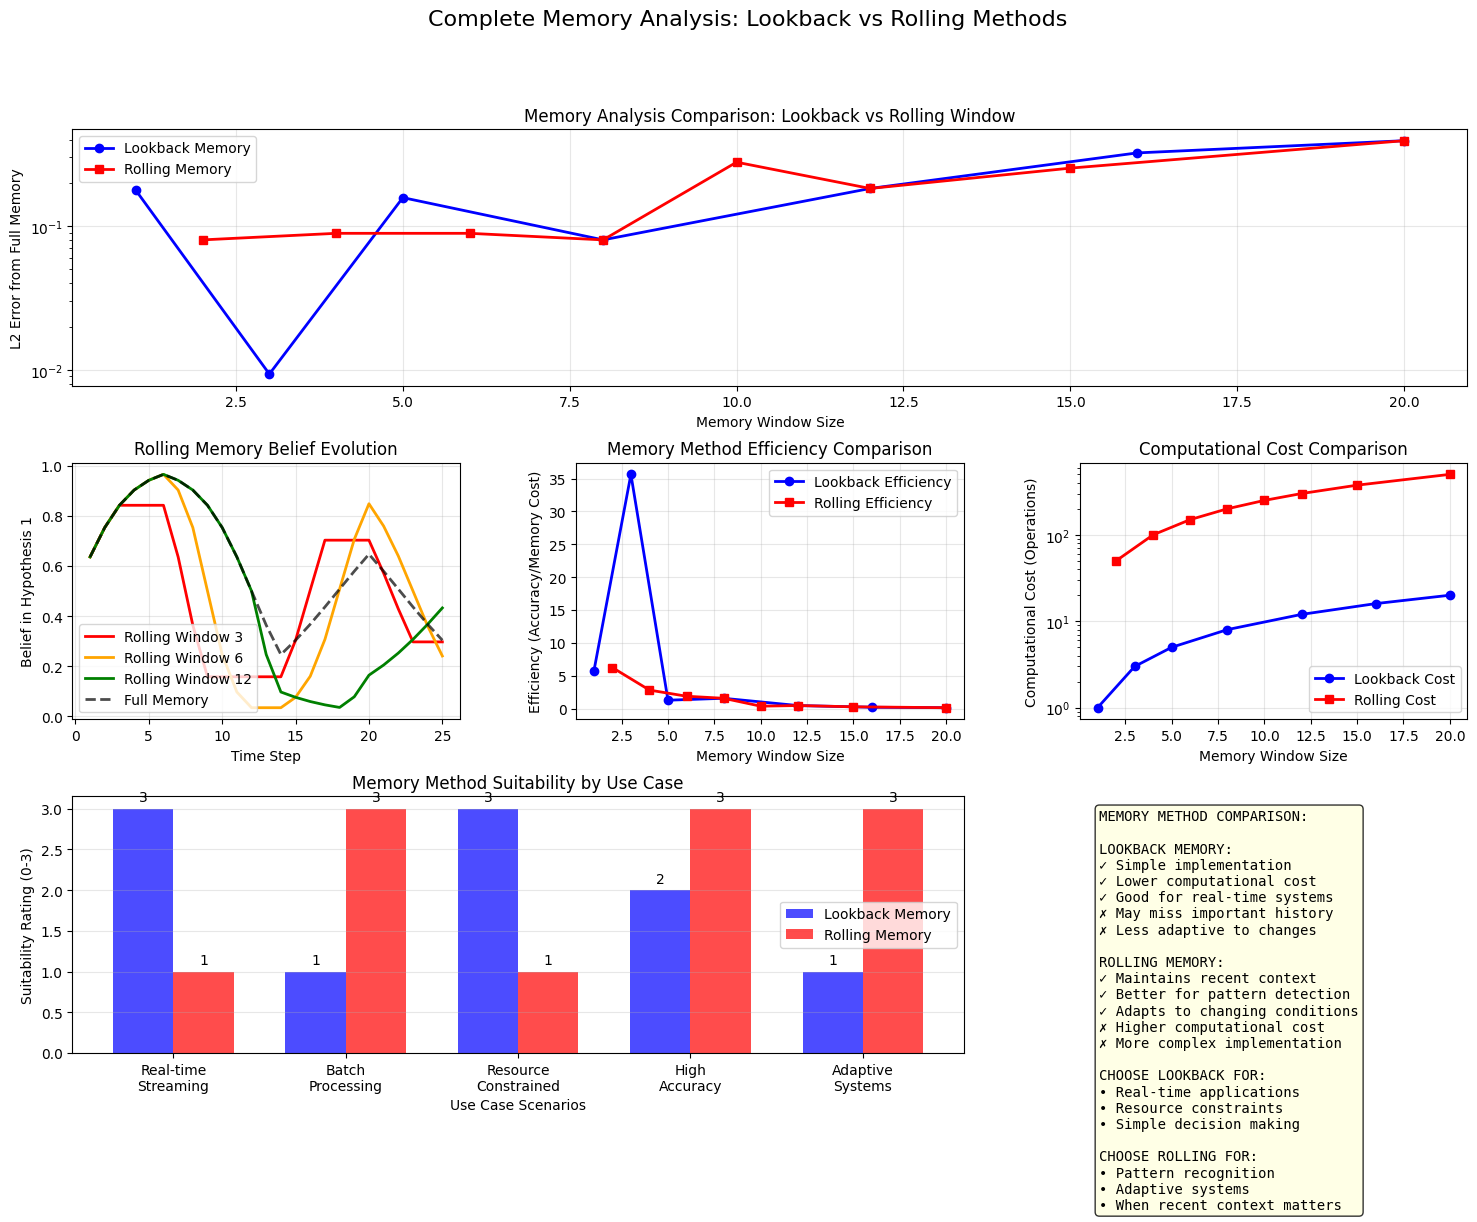

In [ ]:
def plot_complete_memory_analysis(lookback_results, likelihoods):
    """Complete analysis including both lookback and rolling memory"""
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 1], hspace=0.3, wspace=0.3)
    
    # First, compute rolling memory results for comparison
    rolling_windows = [2, 4, 6, 8, 10, 12, 15, 20]
    rolling_results = []
    
    for window_size in rolling_windows:
        result = rolling_memory_analysis(['event'] * len(likelihoods), likelihoods, window_size)
        rolling_results.append(result)
    
    rolling_diffs = [r['difference'] for r in rolling_results]
    rolling_kl = [r['kl_divergence'] for r in rolling_results]
    
    # Extract lookback data
    windows = lookback_results['lookback_windows']
    belief_diffs = lookback_results['belief_differences']
    info_losses = lookback_results['information_loss']
    
    # 1. Direct comparison: Lookback vs Rolling
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot both methods
    ax1.plot(windows[:-1], belief_diffs[:-1], 'b-o', label='Lookback Memory', 
             linewidth=2, markersize=6)
    ax1.plot(rolling_windows, rolling_diffs, 'r-s', label='Rolling Memory', 
             linewidth=2, markersize=6)
    
    ax1.set_xlabel('Memory Window Size')
    ax1.set_ylabel('L2 Error from Full Memory')
    ax1.set_title('Memory Analysis Comparison: Lookback vs Rolling Window')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # 2. Rolling memory trajectory visualization
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Show how rolling memory evolves over time for different window sizes
    test_windows = [3, 6, 12]
    colors = ['red', 'orange', 'green']
    
    for window, color in zip(test_windows, colors):
        rolling_trajectory = []
        recent_evidence = []
        
        for i, likelihood in enumerate(likelihoods):
            recent_evidence.append(likelihood)
            if len(recent_evidence) > window:
                recent_evidence.pop(0)
            
            # Recompute from scratch with current window
            rolling_belief = np.array([0.5, 0.5])
            for recent_like in recent_evidence:
                rolling_belief = bayes_update(rolling_belief, np.array(recent_like))
            
            rolling_trajectory.append(rolling_belief[0])  # Track H1 probability
        
        ax2.plot(range(1, len(rolling_trajectory) + 1), rolling_trajectory, 
                color=color, linewidth=2, label=f'Rolling Window {window}')
    
    # Add full memory trajectory for reference
    full_trajectory = []
    full_belief = np.array([0.5, 0.5])
    for likelihood in likelihoods:
        full_belief = bayes_update(full_belief, np.array(likelihood))
        full_trajectory.append(full_belief[0])
    
    ax2.plot(range(1, len(full_trajectory) + 1), full_trajectory, 
            'k--', linewidth=2, alpha=0.7, label='Full Memory')
    
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Belief in Hypothesis 1')
    ax2.set_title('Rolling Memory Belief Evolution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Memory method efficiency comparison
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Efficiency for lookback (exclude full memory)
    lookback_eff = [1/(d*w) if d > 0 and w > 0 else 0 
                   for d, w in zip(belief_diffs[:-1], windows[:-1])]
    
    # Efficiency for rolling
    rolling_eff = [1/(d*w) if d > 0 and w > 0 else 0 
                  for d, w in zip(rolling_diffs, rolling_windows)]
    
    ax3.plot(windows[:-1], lookback_eff, 'b-o', label='Lookback Efficiency', 
             linewidth=2, markersize=6)
    ax3.plot(rolling_windows, rolling_eff, 'r-s', label='Rolling Efficiency', 
             linewidth=2, markersize=6)
    
    ax3.set_xlabel('Memory Window Size')
    ax3.set_ylabel('Efficiency (Accuracy/Memory Cost)')
    ax3.set_title('Memory Method Efficiency Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Computational cost analysis
    ax4 = fig.add_subplot(gs[1, 2])
    
    # Computational cost: lookback is O(window), rolling is O(window * time)
    time_steps = len(likelihoods)
    lookback_cost = windows[:-1]  # Just the window size
    rolling_cost = [w * time_steps for w in rolling_windows]  # Window * time
    
    ax4.plot(windows[:-1], lookback_cost, 'b-o', label='Lookback Cost', 
             linewidth=2, markersize=6)
    ax4.plot(rolling_windows, rolling_cost, 'r-s', label='Rolling Cost', 
             linewidth=2, markersize=6)
    
    ax4.set_xlabel('Memory Window Size')
    ax4.set_ylabel('Computational Cost (Operations)')
    ax4.set_title('Computational Cost Comparison')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')
    
    # 5. Method selection guide
    ax5 = fig.add_subplot(gs[2, :2])
    
    # Create a decision matrix
    scenarios = ['Real-time\nStreaming', 'Batch\nProcessing', 'Resource\nConstrained', 
                'High\nAccuracy', 'Adaptive\nSystems']
    
    # Ratings: 0=Poor, 1=Fair, 2=Good, 3=Excellent
    lookback_ratings = [3, 1, 3, 2, 1]  # Good for real-time, resource-constrained
    rolling_ratings = [1, 3, 1, 3, 3]   # Good for batch, high-accuracy, adaptive
    
    x = np.arange(len(scenarios))
    width = 0.35
    
    bars1 = ax5.bar(x - width/2, lookback_ratings, width, label='Lookback Memory', 
                   color='blue', alpha=0.7)
    bars2 = ax5.bar(x + width/2, rolling_ratings, width, label='Rolling Memory', 
                   color='red', alpha=0.7)
    
    ax5.set_xlabel('Use Case Scenarios')
    ax5.set_ylabel('Suitability Rating (0-3)')
    ax5.set_title('Memory Method Suitability by Use Case')
    ax5.set_xticks(x)
    ax5.set_xticklabels(scenarios)
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{height}', ha='center', va='bottom')
    
    # 6. Summary recommendations
    ax6 = fig.add_subplot(gs[2, 2])
    ax6.axis('off')
    
    summary_text = """MEMORY METHOD COMPARISON:

LOOKBACK MEMORY:
✓ Simple implementation
✓ Lower computational cost
✓ Good for real-time systems
✗ May miss important history
✗ Less adaptive to changes

ROLLING MEMORY:
✓ Maintains recent context
✓ Better for pattern detection
✓ Adapts to changing conditions
✗ Higher computational cost
✗ More complex implementation

CHOOSE LOOKBACK FOR:
• Real-time applications
• Resource constraints
• Simple decision making

CHOOSE ROLLING FOR:
• Pattern recognition
• Adaptive systems
• When recent context matters"""
    
    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.suptitle('Complete Memory Analysis: Lookback vs Rolling Methods', fontsize=16, y=0.98)
    return fig

# Create the complete analysis
complete_fig = plot_complete_memory_analysis(corrected_results, balanced_likelihoods)
plt.show()


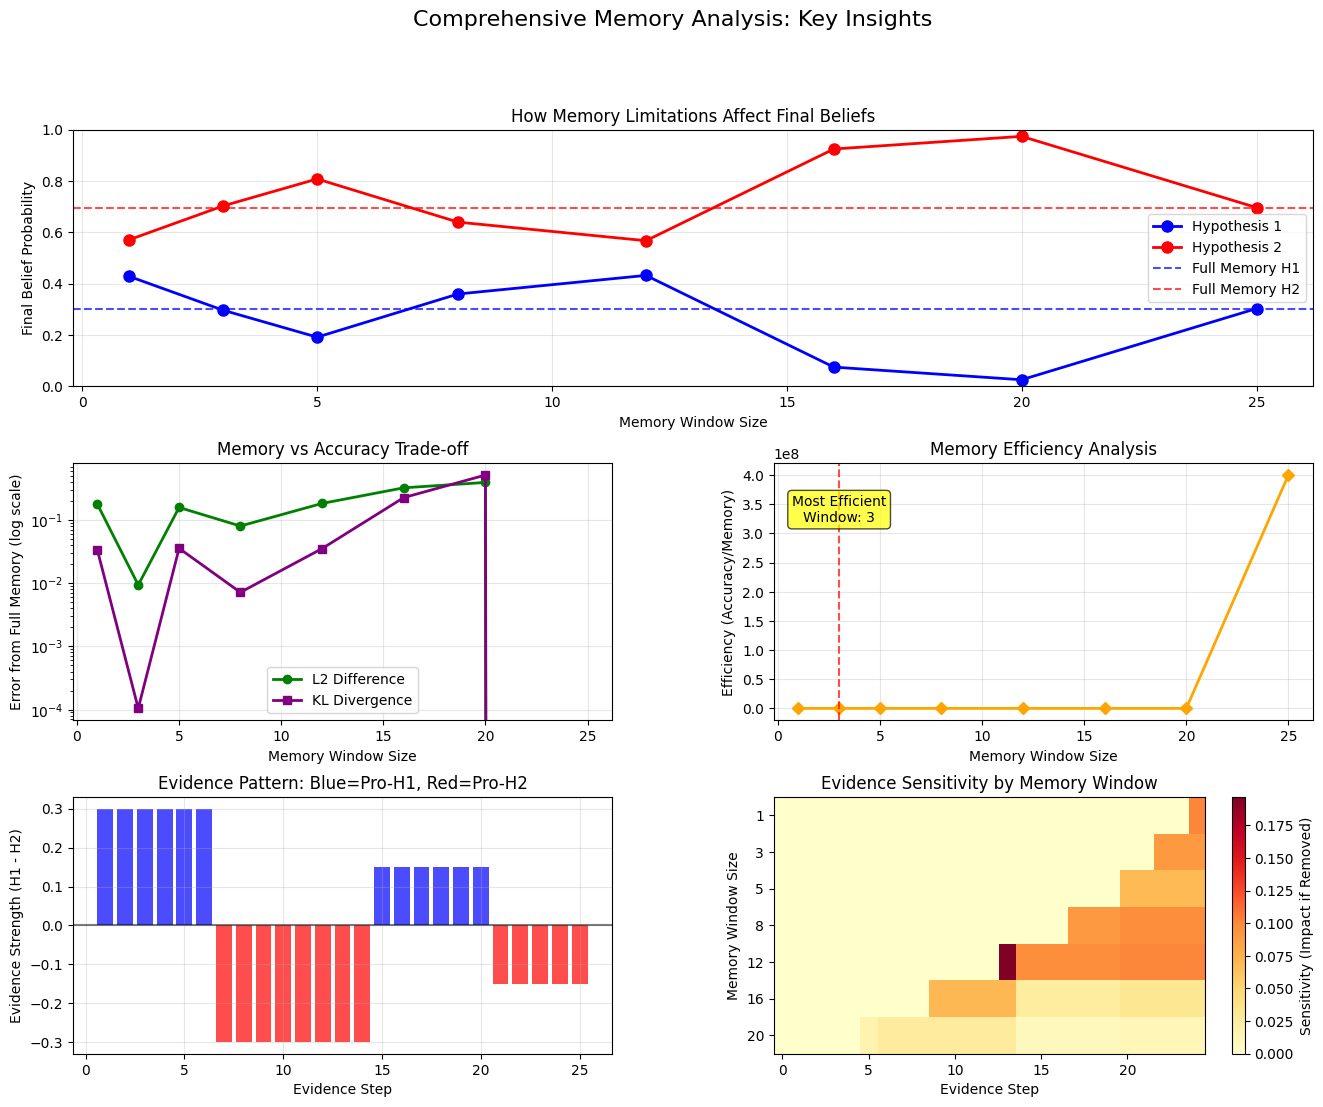

In [ ]:
#| export
def plot_memory_insights(results, likelihoods):
    """Create insightful visualizations of memory effects"""
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], hspace=0.3, wspace=0.3)
    
    windows = results['lookback_windows']
    final_beliefs = np.array(results['final_beliefs'])
    belief_diffs = results['belief_differences']
    info_losses = results['information_loss']
    
    # 1. Memory window effects on final beliefs
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(windows, final_beliefs[:, 0], 'bo-', label='Hypothesis 1', markersize=8, linewidth=2)
    ax1.plot(windows, final_beliefs[:, 1], 'ro-', label='Hypothesis 2', markersize=8, linewidth=2)
    
    # Add full memory reference lines
    full_memory_h1 = final_beliefs[-1, 0]  # Last entry should be full memory
    full_memory_h2 = final_beliefs[-1, 1]
    ax1.axhline(y=full_memory_h1, color='blue', linestyle='--', alpha=0.7, label='Full Memory H1')
    ax1.axhline(y=full_memory_h2, color='red', linestyle='--', alpha=0.7, label='Full Memory H2')
    
    ax1.set_xlabel('Memory Window Size')
    ax1.set_ylabel('Final Belief Probability')
    ax1.set_title('How Memory Limitations Affect Final Beliefs')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # 2. Accuracy vs Memory Trade-off
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.semilogy(windows, belief_diffs, 'g-o', label='L2 Difference', markersize=6, linewidth=2)
    ax2.semilogy(windows, info_losses, 'purple', marker='s', label='KL Divergence', 
                markersize=6, linewidth=2)
    ax2.set_xlabel('Memory Window Size')
    ax2.set_ylabel('Error from Full Memory (log scale)')
    ax2.set_title('Memory vs Accuracy Trade-off')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Memory efficiency analysis
    ax3 = fig.add_subplot(gs[1, 1])
    # Efficiency = accuracy per unit of memory
    # Higher is better (low error per memory unit)
    efficiency = []
    for i, window in enumerate(windows):
        if window == 0:
            eff = 0
        else:
            # Inverse of error per memory unit (higher = more efficient)
            error = max(belief_diffs[i], 1e-10)  # Avoid division by zero
            eff = 1 / (error * window)
        efficiency.append(eff)
    
    ax3.plot(windows, efficiency, 'orange', marker='D', markersize=6, linewidth=2)
    ax3.set_xlabel('Memory Window Size')
    ax3.set_ylabel('Efficiency (Accuracy/Memory)')
    ax3.set_title('Memory Efficiency Analysis')
    ax3.grid(True, alpha=0.3)
    
    # Find and highlight the most efficient window
    max_eff_idx = np.argmax(efficiency[:-1])  # Exclude full memory
    ax3.axvline(x=windows[max_eff_idx], color='red', linestyle='--', alpha=0.7)
    ax3.text(windows[max_eff_idx], max(efficiency) * 0.8, 
             f'Most Efficient\nWindow: {windows[max_eff_idx]}', 
             ha='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    # 4. Evidence pattern analysis
    ax4 = fig.add_subplot(gs[2, 0])
    evidence_strength = [l[0] - l[1] for l in likelihoods]
    colors = ['red' if x < 0 else 'blue' for x in evidence_strength]
    
    bars = ax4.bar(range(1, len(evidence_strength) + 1), evidence_strength, 
                   color=colors, alpha=0.7)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax4.set_xlabel('Evidence Step')
    ax4.set_ylabel('Evidence Strength (H1 - H2)')
    ax4.set_title('Evidence Pattern: Blue=Pro-H1, Red=Pro-H2')
    ax4.grid(True, alpha=0.3)
    
    # 5. Memory sensitivity heatmap
    ax5 = fig.add_subplot(gs[2, 1])
    
    # Create a sensitivity matrix: how much does each piece of evidence matter
    # for different memory windows?
    n_evidence = len(likelihoods)
    sensitivity_matrix = np.zeros((len(windows[:-1]), n_evidence))  # Exclude full memory
    
    for i, window in enumerate(windows[:-1]):  # Exclude full memory
        if window >= n_evidence:
            continue
        start_idx = n_evidence - window
        
        # Test removing each piece of evidence within the window
        for j in range(start_idx, n_evidence):
            # Compute belief without evidence j
            test_belief = np.array([0.5, 0.5])
            for k in range(start_idx, n_evidence):
                if k != j:  # Skip evidence j
                    test_belief = bayes_update(test_belief, np.array(likelihoods[k]))
            
            # Sensitivity = how much removing this evidence changes the result
            original_belief = final_beliefs[i]
            sensitivity = np.linalg.norm(original_belief - test_belief)
            sensitivity_matrix[i, j] = sensitivity
    
    im = ax5.imshow(sensitivity_matrix, cmap='YlOrRd', aspect='auto')
    ax5.set_xlabel('Evidence Step')
    ax5.set_ylabel('Memory Window Size')
    ax5.set_title('Evidence Sensitivity by Memory Window')
    ax5.set_yticks(range(len(windows[:-1])))
    ax5.set_yticklabels([str(w) for w in windows[:-1]])
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax5)
    cbar.set_label('Sensitivity (Impact if Removed)')
    
    plt.suptitle('Comprehensive Memory Analysis: Key Insights', fontsize=16, y=0.98)
    return fig

# Create the comprehensive insights plot
insights_fig = plot_memory_insights(corrected_results, balanced_likelihoods)
plt.show()


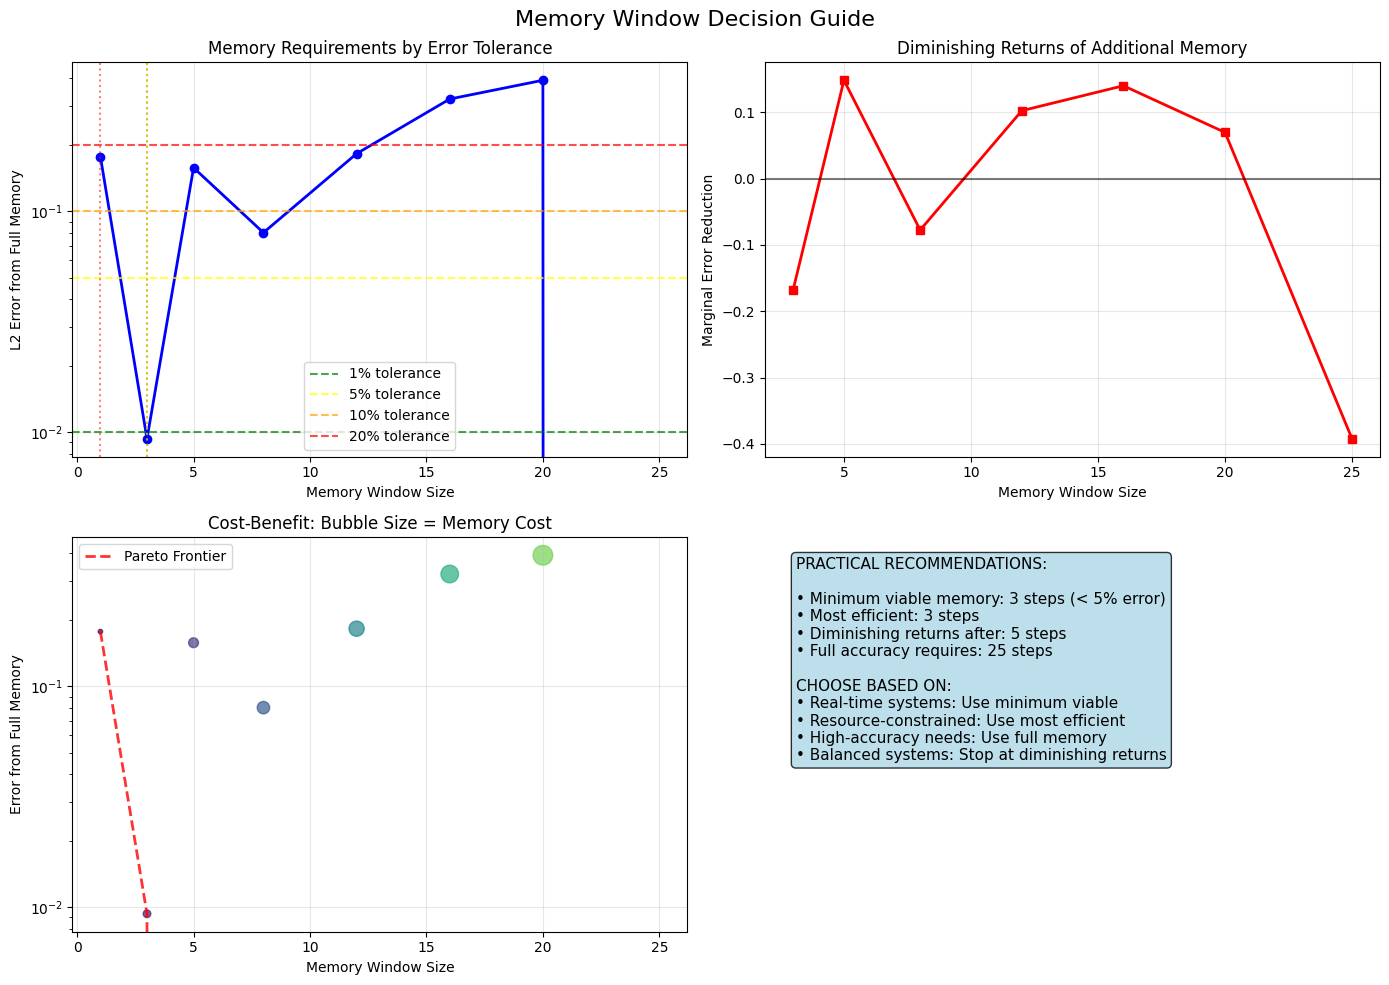

In [ ]:
#| export
def plot_memory_decision_guide(results):
    """Create a practical decision guide for choosing memory window size"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    windows = results['lookback_windows']
    belief_diffs = results['belief_differences']
    info_losses = results['information_loss']
    
    # 1. Error tolerance guide
    ax1.plot(windows, belief_diffs, 'b-o', linewidth=2, markersize=6)
    
    # Add tolerance threshold lines
    tolerances = [0.01, 0.05, 0.1, 0.2]
    colors = ['green', 'yellow', 'orange', 'red']
    
    for tol, color in zip(tolerances, colors):
        ax1.axhline(y=tol, color=color, linestyle='--', alpha=0.7, 
                   label=f'{tol:.0%} tolerance')
        
        # Find minimum window size for this tolerance
        valid_windows = [w for w, diff in zip(windows, belief_diffs) if diff <= tol]
        if valid_windows:
            min_window = min(valid_windows)
            ax1.axvline(x=min_window, color=color, linestyle=':', alpha=0.5)
    
    ax1.set_xlabel('Memory Window Size')
    ax1.set_ylabel('L2 Error from Full Memory')
    ax1.set_title('Memory Requirements by Error Tolerance')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # 2. Diminishing returns analysis
    ax2.plot(windows[1:], np.diff(belief_diffs), 'r-s', linewidth=2, markersize=6)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.set_xlabel('Memory Window Size')
    ax2.set_ylabel('Marginal Error Reduction')
    ax2.set_title('Diminishing Returns of Additional Memory')
    ax2.grid(True, alpha=0.3)
    
    # 3. Cost-benefit analysis
    ax3.scatter(windows, belief_diffs, s=[w*10 for w in windows], 
               c=windows, cmap='viridis', alpha=0.7)
    ax3.set_xlabel('Memory Window Size')
    ax3.set_ylabel('Error from Full Memory')
    ax3.set_title('Cost-Benefit: Bubble Size = Memory Cost')
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')
    
    # Add pareto frontier
    pareto_points = []
    for i, (w, err) in enumerate(zip(windows, belief_diffs)):
        is_pareto = True
        for j, (w2, err2) in enumerate(zip(windows, belief_diffs)):
            if i != j and w2 <= w and err2 <= err and (w2 < w or err2 < err):
                is_pareto = False
                break
        if is_pareto:
            pareto_points.append((w, err))
    
    if pareto_points:
        pareto_points.sort()
        pareto_w, pareto_err = zip(*pareto_points)
        ax3.plot(pareto_w, pareto_err, 'r--', linewidth=2, alpha=0.8, label='Pareto Frontier')
        ax3.legend()
    
    # 4. Practical recommendations
    ax4.axis('off')
    
    # Generate recommendations based on the data
    recommendations = []
    
    # Find minimum viable window (< 5% error)
    viable_windows = [w for w, diff in zip(windows, belief_diffs) if diff <= 0.05]
    if viable_windows:
        min_viable = min(viable_windows)
        recommendations.append(f"• Minimum viable memory: {min_viable} steps (< 5% error)")
    
    # Find efficiency sweet spot
    efficiency = [1/(d*w) if d > 0 else 0 for d, w in zip(belief_diffs[:-1], windows[:-1])]
    if efficiency:
        best_eff_idx = np.argmax(efficiency)
        recommendations.append(f"• Most efficient: {windows[best_eff_idx]} steps")
    
    # Find diminishing returns point
    if len(belief_diffs) > 1:
        improvements = [-np.diff(belief_diffs)[i] for i in range(len(windows)-1)]
        if improvements:
            # Find where improvement drops below 10% of maximum
            max_improvement = max(improvements)
            threshold = max_improvement * 0.1
            diminishing_idx = next((i for i, imp in enumerate(improvements) 
                                  if imp < threshold), len(improvements)-1)
            recommendations.append(f"• Diminishing returns after: {windows[diminishing_idx+1]} steps")
    
    recommendations.append(f"• Full accuracy requires: {windows[-1]} steps")
    
    # Display recommendations
    rec_text = "PRACTICAL RECOMMENDATIONS:\n\n" + "\n".join(recommendations)
    rec_text += "\n\nCHOOSE BASED ON:\n"
    rec_text += "• Real-time systems: Use minimum viable\n"
    rec_text += "• Resource-constrained: Use most efficient\n" 
    rec_text += "• High-accuracy needs: Use full memory\n"
    rec_text += "• Balanced systems: Stop at diminishing returns"
    
    ax4.text(0.05, 0.95, rec_text, transform=ax4.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.suptitle('Memory Window Decision Guide', fontsize=16)
    plt.tight_layout()
    return fig

# Create the decision guide
decision_fig = plot_memory_decision_guide(corrected_results)
plt.show()


## Cybersecurity Applications

Let's apply recursive updating to realistic cybersecurity scenarios.

In [ ]:
#| export
def update_baseline(current_baseline, observation, adaptation_rate):
    """Update baseline using exponential moving average"""
    return (1 - adaptation_rate) * current_baseline + adaptation_rate * observation

In [ ]:
#| export
def multi_step_attack_detection(event_sequence, attack_patterns, 
                                       window_size=5, threshold=0.6):
    """Improved multi-step attack detection with better calibration"""
    
    # Start with more neutral beliefs - less confident about benign state
    pattern_beliefs = {}
    for pattern_name in attack_patterns:
        pattern_beliefs[pattern_name] = np.array([0.7, 0.3])  # Less confident start
    
    results = {
        'time_steps': [],
        'pattern_probabilities': {name: [] for name in attack_patterns},
        'alerts': [],
        'detected_patterns': []
    }
    
    print("=== IMPROVED MULTI-STEP ATTACK DETECTION ===")
    
    for t, event in enumerate(event_sequence):
        alerts_this_step = []
        detected_this_step = []
        
        print(f"\nTime step {t}: Event = {event}")
        
        for pattern_name, pattern_steps in attack_patterns.items():
            current_belief = pattern_beliefs[pattern_name]
            
            if event in pattern_steps:
                # Strong evidence for attack when event matches pattern
                likelihood = np.array([0.1, 0.9])  # 90% evidence for attack
            else:
                # Moderate evidence against attack when no match
                likelihood = np.array([0.8, 0.2])  # 80% evidence for benign
            
            # Recursive Bayesian update
            updated_belief = bayes_update(current_belief, likelihood)
            pattern_beliefs[pattern_name] = updated_belief
            
            # Check for detection
            attack_prob = updated_belief[1]
            alert = attack_prob > threshold
            
            if alert:
                alerts_this_step.append(pattern_name)
                detected_this_step.append(pattern_name)
            
            print(f"  {pattern_name}: Match={event in pattern_steps}, P(attack)={attack_prob:.3f}, Alert={alert}")
            
            results['pattern_probabilities'][pattern_name].append(attack_prob)
        
        results['time_steps'].append(t)
        results['alerts'].append(alerts_this_step)
        results['detected_patterns'].append(detected_this_step)
    
    return results

In [ ]:
#| export
def adaptive_threat_monitor(baseline_behavior, time_series_data, 
                         adaptation_rate=0.01, threshold=0.6,
                         decay_rate=0.1):  # Add memory decay
    """Refined version with better memory management"""
    
    threat_belief = np.array([0.6, 0.4])  # Slightly less neutral start
    original_baseline = float(baseline_behavior)
    
    results = {'time_steps': [], 'threat_probabilities': [], 'alerts': [], 'observations': []}
    
    print("=== REFINED THREAT MONITORING ===")
    
    for t, observation in enumerate(time_series_data):
        absolute_deviation = abs(observation - original_baseline)
        deviation_percentage = (absolute_deviation / original_baseline) * 100
        
        # More balanced likelihood functions
        if deviation_percentage < 5:     # Very close to baseline
            likelihood = np.array([0.9, 0.1])
        elif deviation_percentage < 15:  # Small deviation
            likelihood = np.array([0.7, 0.3])
        elif deviation_percentage < 40:  # Moderate deviation
            likelihood = np.array([0.3, 0.7])
        else:  # Large deviation
            likelihood = np.array([0.1, 0.9])
        
        # Bayesian update
        threat_belief = bayes_update(threat_belief, likelihood)
        
        # Add memory decay - gradually return toward neutral when no strong evidence
        if deviation_percentage < 10:  # Only decay during normal periods
            threat_belief[1] = threat_belief[1] * (1 - decay_rate) + 0.4 * decay_rate
            threat_belief[0] = 1 - threat_belief[1]
        
        alert = threat_belief[1] > threshold
        
        results['time_steps'].append(t)
        results['threat_probabilities'].append(threat_belief[1])
        results['alerts'].append(alert)
        results['observations'].append(observation)
        
        print(f"Time {t}: Obs={observation:.1f}, DevPct={deviation_percentage:.1f}%, " +
              f"Threat={threat_belief[1]:.3f}, Alert={alert}")
    
    return results

In [ ]:
# Demonstrate adaptive threat monitoring
print("Example: Network Traffic Monitoring")
baseline = 100  # Baseline network traffic (packets/sec)
traffic_data = [95, 102, 98, 105, 150, 180, 160, 110, 95, 200, 220, 190, 100, 98]

monitoring_results = adaptive_threat_monitor(
    baseline, traffic_data, 
    adaptation_rate=0.2, threshold=0.6, decay_rate=0.15
)

print(f"\nSummary: {sum(monitoring_results['alerts'])} alerts generated")
print(f"Alert steps: {[i for i, alert in enumerate(monitoring_results['alerts']) if alert]}")



Example: Network Traffic Monitoring
=== REFINED THREAT MONITORING ===
Time 0: Obs=95.0, DevPct=5.0%, Threat=0.249, Alert=False
Time 1: Obs=102.0, DevPct=2.0%, Threat=0.090, Alert=False
Time 2: Obs=98.0, DevPct=2.0%, Threat=0.069, Alert=False
Time 3: Obs=105.0, DevPct=5.0%, Threat=0.086, Alert=False
Time 4: Obs=150.0, DevPct=50.0%, Threat=0.459, Alert=False
Time 5: Obs=180.0, DevPct=80.0%, Threat=0.884, Alert=True
Time 6: Obs=160.0, DevPct=60.0%, Threat=0.986, Alert=True
Time 7: Obs=110.0, DevPct=10.0%, Threat=0.967, Alert=True
Time 8: Obs=95.0, DevPct=5.0%, Threat=0.848, Alert=True
Time 9: Obs=200.0, DevPct=100.0%, Threat=0.980, Alert=True
Time 10: Obs=220.0, DevPct=120.0%, Threat=0.998, Alert=True
Time 11: Obs=190.0, DevPct=90.0%, Threat=1.000, Alert=True
Time 12: Obs=100.0, DevPct=0.0%, Threat=0.908, Alert=True
Time 13: Obs=98.0, DevPct=2.0%, Threat=0.505, Alert=False

Summary: 8 alerts generated
Alert steps: [5, 6, 7, 8, 9, 10, 11, 12]


In [ ]:

# Demonstrate multi-step attack detection  
print("\n" + "="*50)
print("Example: Multi-step Attack Detection")

attack_patterns = {
    'Reconnaissance': ['port_scan', 'dns_lookup', 'service_enum'],
    'Lateral_Movement': ['credential_theft', 'remote_login', 'privilege_escalation'], 
    'Data_Exfiltration': ['database_access', 'file_compression', 'network_transfer']
}

event_sequence = ['port_scan', 'normal_traffic', 'dns_lookup', 'credential_theft', 
                 'service_enum', 'remote_login', 'normal_traffic', 'database_access']

attack_results = multi_step_attack_detection(
    event_sequence, attack_patterns, threshold=0.6
)

detected_patterns = set([p for patterns in attack_results['detected_patterns'] for p in patterns])
print(f"\nDetected attack patterns: {detected_patterns if detected_patterns else 'None'}")


Example: Multi-step Attack Detection
=== IMPROVED MULTI-STEP ATTACK DETECTION ===

Time step 0: Event = port_scan
  Reconnaissance: Match=True, P(attack)=0.794, Alert=True
  Lateral_Movement: Match=False, P(attack)=0.097, Alert=False
  Data_Exfiltration: Match=False, P(attack)=0.097, Alert=False

Time step 1: Event = normal_traffic
  Reconnaissance: Match=False, P(attack)=0.491, Alert=False
  Lateral_Movement: Match=False, P(attack)=0.026, Alert=False
  Data_Exfiltration: Match=False, P(attack)=0.026, Alert=False

Time step 2: Event = dns_lookup
  Reconnaissance: Match=True, P(attack)=0.897, Alert=True
  Lateral_Movement: Match=False, P(attack)=0.007, Alert=False
  Data_Exfiltration: Match=False, P(attack)=0.007, Alert=False

Time step 3: Event = credential_theft
  Reconnaissance: Match=False, P(attack)=0.685, Alert=True
  Lateral_Movement: Match=True, P(attack)=0.057, Alert=False
  Data_Exfiltration: Match=False, P(attack)=0.002, Alert=False

Time step 4: Event = service_enum
  Recon

## When Recursion Breaks Down

Recursive updating isn't always optimal. Let's explore scenarios where it struggles and potential solutions.

=== NON-STATIONARITY CHALLENGES ===
Standard Recursive: Mean error = 6.847
Forgetting Factor: Mean error = 3.231
Sliding Window: Mean error = 2.824


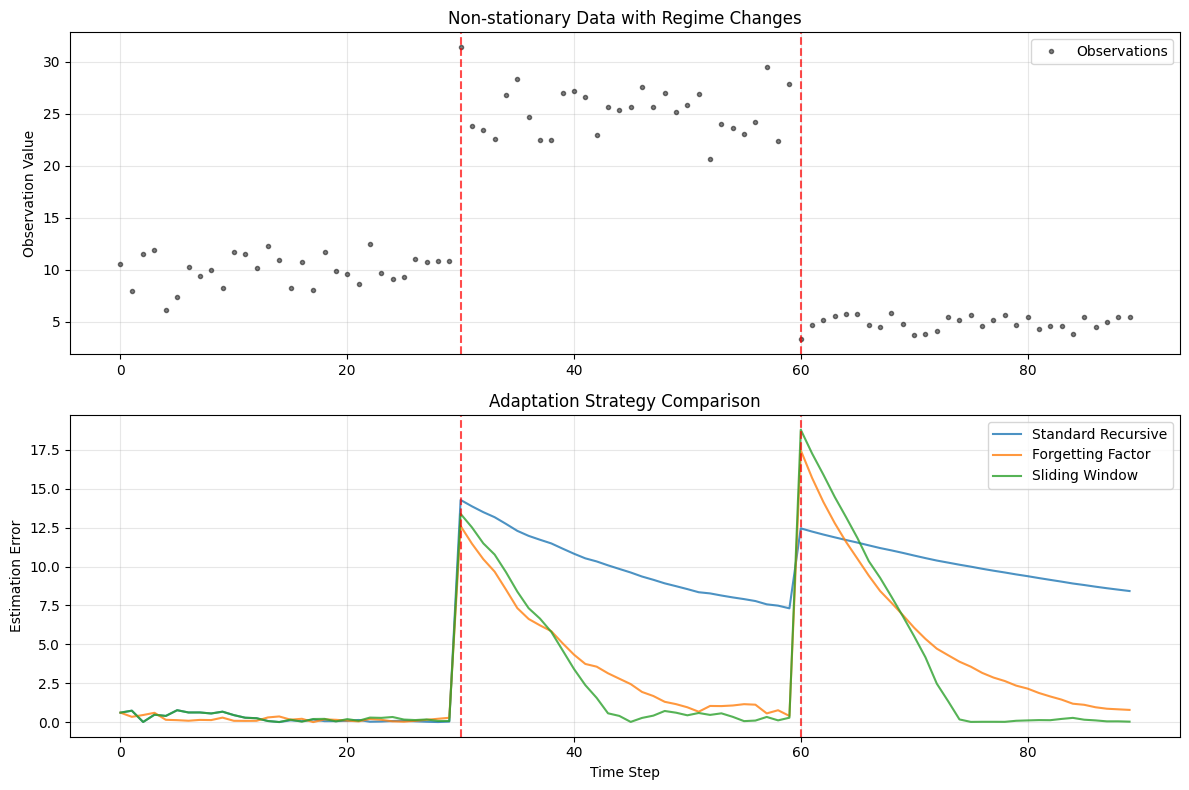


Key insights:
- Standard recursive filtering fails with regime changes
- Forgetting factors help adapt to new regimes
- Sliding windows provide good balance of adaptation and stability
- Choice depends on expected change frequency and noise levels


In [ ]:
#| export
def non_stationary_demo(change_points, segment_patterns, n_observations=100):
    """Demonstrate challenges with non-stationary data"""
    rng = np.random.default_rng(42)
    
    # Generate non-stationary data
    observations = []
    true_states = []
    current_segment = 0
    
    for t in range(n_observations):
        # Check for regime change
        if current_segment < len(change_points) and t >= change_points[current_segment]:
            current_segment += 1
        
        # Generate observation from current pattern
        pattern = segment_patterns[min(current_segment, len(segment_patterns) - 1)]
        obs = rng.normal(pattern['mean'], pattern['std'])
        observations.append(obs)
        true_states.append(current_segment)
    
    return observations, true_states

def compare_adaptation_strategies(observations, true_states, strategies):
    """Compare different adaptation strategies for non-stationary data"""
    results = {name: {'estimates': [], 'errors': []} for name in strategies}
    
    for strategy_name, strategy_fn in strategies.items():
        estimates = strategy_fn(observations)
        errors = [abs(est - true) for est, true in zip(estimates, true_states)]
        
        results[strategy_name]['estimates'] = estimates
        results[strategy_name]['errors'] = errors
        
        print(f"{strategy_name}: Mean error = {np.mean(errors):.3f}")
    
    return results

def forgetting_factor_filter(observations, forgetting_factor=0.95):
    """Simple filter with exponential forgetting"""
    estimates = []
    current_estimate = observations[0] if observations else 0
    
    for obs in observations:
        current_estimate = forgetting_factor * current_estimate + (1 - forgetting_factor) * obs
        estimates.append(current_estimate)
    
    return estimates

def windowed_filter(observations, window_size=20):
    """Simple windowed mean filter"""
    estimates = []
    
    for i, obs in enumerate(observations):
        start_idx = max(0, i - window_size + 1)
        window_data = observations[start_idx:i+1]
        estimates.append(np.mean(window_data))
    
    return estimates

def standard_recursive_filter(observations):
    """Standard recursive mean (no adaptation)"""
    estimates = []
    running_mean = 0
    
    for i, obs in enumerate(observations):
        running_mean = (running_mean * i + obs) / (i + 1)
        estimates.append(running_mean)
    
    return estimates

# Demonstrate non-stationarity challenges
print("=== NON-STATIONARITY CHALLENGES ===")

# Define regime changes
change_points = [30, 60]
segment_patterns = [
    {'mean': 10, 'std': 2},   # Regime 1
    {'mean': 25, 'std': 3},   # Regime 2  
    {'mean': 5, 'std': 1}     # Regime 3
]

obs_data, true_regimes = non_stationary_demo(change_points, segment_patterns, 90)

# Compare adaptation strategies
strategies = {
    'Standard Recursive': standard_recursive_filter,
    'Forgetting Factor': lambda x: forgetting_factor_filter(x, 0.9),
    'Sliding Window': lambda x: windowed_filter(x, 15)
}

adaptation_results = compare_adaptation_strategies(obs_data, [p['mean'] for p in segment_patterns for _ in range(30)], strategies)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Top: Observations and true regime changes
time_steps = np.arange(len(obs_data))
ax1.plot(time_steps, obs_data, 'k.', alpha=0.5, label='Observations')

# Mark regime changes
for cp in change_points:
    ax1.axvline(cp, color='red', linestyle='--', alpha=0.7)

ax1.set_ylabel('Observation Value')
ax1.set_title('Non-stationary Data with Regime Changes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Estimation errors
for strategy_name, strategy_data in adaptation_results.items():
    ax2.plot(time_steps, strategy_data['errors'], label=strategy_name, alpha=0.8)

for cp in change_points:
    ax2.axvline(cp, color='red', linestyle='--', alpha=0.7)

ax2.set_xlabel('Time Step')
ax2.set_ylabel('Estimation Error')
ax2.set_title('Adaptation Strategy Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey insights:")
print("- Standard recursive filtering fails with regime changes")
print("- Forgetting factors help adapt to new regimes")
print("- Sliding windows provide good balance of adaptation and stability")
print("- Choice depends on expected change frequency and noise levels")

## Summary and Key Takeaways

Recursive Bayesian updating transforms static inference into dynamic, adaptive learning:

### **Mathematical Elegance**
- **Recursive structure**: Today's posterior becomes tomorrow's prior
- **Markov property**: Future depends only on present state
- **Optimality**: Mathematically optimal under stationarity assumptions

### **Computational Advantages**
- **Memory efficiency**: O(1) storage vs O(n) for batch processing
- **Real-time capability**: Updates as evidence arrives
- **Scalability**: Performance independent of history length

### **Practical Applications**
- **Threat monitoring**: Adaptive baselines for anomaly detection
- **Attack detection**: Multi-step pattern recognition
- **State tracking**: Object tracking and motion estimation

### **Limitations and Solutions**
- **Non-stationarity**: Use forgetting factors or sliding windows
- **Model mismatch**: Robust estimation techniques
- **Computational complexity**: Approximate methods (particle filters)

### **Integration with Modern AI**
- **Hybrid approaches**: Combine with neural networks
- **Meta-learning**: Learn to adapt adaptation parameters
- **Uncertainty quantification**: Maintain probabilistic reasoning

The recursive nature of Bayesian updating makes it particularly powerful for cybersecurity applications where threats evolve continuously and decisions must be made in real-time with limited computational resources.

In [ ]:
#| export
__all__ = [
    # Core recursive functions
    'recursive_bayes_demo', 'particle_filter', 'markov_chain_demo',
    
    # Interactive components
    'belief_evolution_visualizer', 'recursive_update_component',
    
    # Performance analysis
    'batch_vs_recursive_comparison', 'plot_performance_comparison',
    
    # Memory analysis
    'memory_analysis', 'plot_memory_analysis', 
    
    # Cybersecurity applications
    'adaptive_threat_monitor', 'multi_step_attack_detection',
    
    # Non-stationarity handling
    'non_stationary_demo', 'compare_adaptation_strategies',
    'forgetting_factor_filter', 'windowed_filter', 'standard_recursive_filter'
]